# Исследование объявлений о продаже квартир

## Общее описание проекта 
В распоряжении данные сервиса о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно изучить влияние различных факторов на рыночную стоимость объектов недвижимости. 

## Описание признакового пространства 
По каждой квартире на продажу доступны следующие признаки. 

|Признак|Описание признака|
|-------------:|:------------|
|airports_nearest|расстояние до ближайшего аэропорта в метрах (м)|
|balcony|число балконов|
|ceiling_height|высота потолков (м)|
|cityCenters_nearest|расстояние до центра города (м)|
|days_exposition| сколько дней было размещено объявление (от публикации до снятия)|
|first_day_exposition|дата публикации|
|floor|этаж|
|floors_total| всего этажей в доме|
|is_apartment|апартаменты (булев тип)|
|kitchen_area|площадь кухни в квадратных метрах (м²)|
|last_price|цена на момент снятия с публикации|
|living_area|жилая площадь в квадратных метрах(м²)|
|locality_name|название населённого пункта|
|open_plan|свободная планировка (булев тип)|
|parks_around3000|число парков в радиусе 3 км|
|parks_nearest|расстояние до ближайшего парка (м)|
|ponds_around3000|число водоёмов в радиусе 3 км|
|ponds_nearest|расстояние до ближайшего водоёма (м)|
|rooms|число комнат|
|studio|квартира-студия (булев тип)|
|total_area|площадь квартиры в квадратных метрах (м²)|
|total_images|число фотографий квартиры в объявлении|

Пояснение: апартаменты — это нежилые помещения, не относящиеся к жилому фонду, но имеющие необходимые условия для проживания.

## Инструкции по выполнению проекта

Шаг 1. Откройте файл с данными и изучите общую информацию

Шаг 2. Предобработка данных
- Обработать аномальные наблюдения;
- Привести данные к необходимым типам;
- Исследовать дублирующиеся записи;
- Обработать пропущенные значения.

Шаг 3. Посчитайте и добавьте в таблицу:
цену квадратного метра;
день недели, месяц и год публикации объявления;
этаж квартиры; варианты — первый, последний, другой;
соотношение жилой и общей площади, а также отношение площади кухни к общей.

Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:
- Изучите следующие параметры: площадь, цена, число комнат, высота потолков. Постройте гистограммы для каждого параметра.
- Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. 
- Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от площади, числа комнат, удалённости от центра. Изучите зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом. Также изучите зависимость от даты размещения: дня недели, месяца и года.
- Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите среди них населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце 'locality_name'.
- Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге ('locality_name'). 
- Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). 

Шаг 5. Проверьте гипотезы о равенстве стоимости квартир в центральной части Санкт-Петербурге и других квартир.

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans

from scipy import stats as st
import math 

pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150
pd.options.display.precision = 2
pd.options.display.float_format ='{:.2f}'.format

In [2]:
df  = pd.read_csv("project7.csv", sep = "\t")
df.head(2)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.00,108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,18863.00,16028.00,1.00,482.00,2.00,755.00,NaN
1,7,3350000.00,40.40,2018-12-04T00:00:00,1,NaN,11.00,18.60,1,NaN,False,False,11.00,2.00,посёлок Шушары,12817.00,18603.00,0.00,NaN,0.00,NaN,81.00


In [3]:
dict_to_rus = {"total_images":"число фотографий",
               "airports_nearest":"расстояние до аэропорта",
               "balcony": "число балконов",
               "ceiling_height":"высота потолков",
               "cityCenters_nearest":"расстояние до центра города",
               "days_exposition": "сколько дней размещено объявление",
               "first_day_exposition":"дата публикации",
               "floor":"этаж",
               "floors_total": "всего этажей в доме",
               "is_apartment":"апартаменты",
               "kitchen_area":"площадь кухни",
               "last_price":"цена",
               "living_area":"жилая площадь",
               "locality_name":"название населённого пункта",
               "open_plan": "свободная планировка",
               "parks_around3000":"число парков в радиусе 3 км",
               "parks_nearest":"расстояние до ближайшего парка",
               "ponds_around3000":"число водоёмов в радиусе 3 км",
               "ponds_nearest":"расстояние до ближайшего водоёма",
               "rooms" : "число комнат",
               "studio": "квартира-студия",
               "total_area": "площадь квартиры в квадратных метрах",
               "floor_type": "на каком этаже находится квартира",
              "w_year": "год размещения объявления",
               "w_month": "месяц размещения объявления"}

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [5]:
df.describe(include = 'all', percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.95, 0.99]).T

,count,unique,top,freq,mean,std,min,1%,5%,10%,25%,50%,75%,95%,99%,max
total_images,23699.00,NaN,NaN,NaN,9.86,5.68,0.00,0.00,1.00,2.00,6.00,9.00,14.00,20.00,20.00,50.00
last_price,23699.00,NaN,NaN,NaN,6541548.77,10887013.27,12190.00,1000000.00,1870000.00,2500000.00,3400000.00,4650000.00,6800000.00,15300000.00,36000000.00,763000000.00
total_area,23699.00,NaN,NaN,NaN,60.35,35.65,12.00,25.20,31.00,33.00,40.00,52.00,69.90,116.00,197.21,900.00
first_day_exposition,23699,1491,2018-02-01T00:00:00,368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rooms,23699.00,NaN,NaN,NaN,2.07,1.08,0.00,1.00,1.00,1.00,1.00,2.00,3.00,4.00,5.00,19.00
ceiling_height,14504.00,NaN,NaN,NaN,2.77,1.26,1.00,2.50,2.50,2.50,2.52,2.65,2.80,3.30,3.83,100.00
floors_total,23613.00,NaN,NaN,NaN,10.67,6.60,1.00,2.00,4.00,5.00,5.00,9.00,16.00,25.00,26.00,60.00
living_area,21796.00,NaN,NaN,NaN,34.46,22.03,2.00,13.00,15.20,16.40,18.60,30.00,42.30,69.00,120.00,409.70
floor,23699.00,NaN,NaN,NaN,5.89,4.89,1.00,1.00,1.00,1.00,2.00,4.00,8.00,16.00,23.00,33.00
is_apartment,2775,2,False,2725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#Выводы из профиля данных

Результаты проведенного первичного обследования полученной выборки позволяют сделать следующие выводы: 

|Признак|Наименование на русском|Комментарий|
|--:|:--|:--|
|`total_images`|число фотографий квартиры в объявлении|аномалий нет, тип соответствует|
|`last_price`|цена на момент снятия с публикации|есть аномалии по сумме - нужно проверить минимальную цену, тип соответствует, пропусков нет|
|`total_area`|площадь квартиры в квадратных метрах (м²)|пропусков нет, тип соответствует, min - 12 кв.м проверить |
|`first_day_exposition`|дата публикации| тип - object, пропусков нет |
|`rooms`|число комнат| пропусков нет, тип соответствует, проверить 0 значения |
|`ceiling_height`|высота потолков(м)| много пропусков, есть  аномальные мин значения 1 кв.м. и мах значения, тип соответствует |
|`floors_total`|всего этажей в доме| тип -float64, есть небольшие пропуски |
|`living_area`|жилая площадь в квадратных метрах(м²)| есть пропущенные значения, проверить 2 кв.м., тип соответствует, проверить, чтобы не было меньше чем total_area  |
|`floor`|этаж| аномалий нет, тип соответствует, проверить на соответсвие с floors_total, чтобы не было больше |
|`is_apartment`|апартаменты (булев тип)| пропущенные значения, тип не соответствует|
|`studio`|квартира-студия (булев тип)| аномалий нет, тип соответствует, проверить с rooms в студии не должно быть больше 1 комнаты|
|`open_plan`|свободная планировка (булев тип)|аномалий нет, тип соответствует |
|`kitchen_area`|площадь кухни в квадратных метрах (м²)| проверить min и  max значение, есть пропуски, тип соответствует |
|`balcony`|число балконов| тип не соответствует, есть пропущенные значения |
|`locality_name`|название населённого пункта| есть пропуски, тип соответствует |
|`airports_nearest`|расстояние до ближайшего аэропорта в метрах (м)| есть пропуски, есть нулевые значения - проверить, тип соответствует |
|`cityCenters_nearest`|расстояние до центра города (м)| есть пропуски, тип соответствует, проверить max |
|`parks_around3000`|число парков в радиусе 3 км|есть пропуски, тип не соответствует, |
|`parks_nearest`|расстояние до ближайшего парка (м)| есть пропуски, тип соответствует, - необходимо проверить на соответсвие с parks_around3000|
|`ponds_around3000`|число водоёмов в радиусе 3 км| есть пропуски, тип не соответствует|
|`ponds_nearest`|расстояние до ближайшего водоёма (м)| есть пропуски, тип соответствует, необходимо проверить на соответствие с ponds_around3000|
|`days_exposition`|сколько дней было размещено объявление (от публикации до снятия)| есть пропуски, тип  не соответствует|

## $\checkmark$ Проверка на дублирующееся записи

In [6]:
print("Количество дублирубщихся данных  - {}".format(df.duplicated().sum()))

Количество дублирубщихся данных  - 0


## $\checkmark$ Приведение данных к необходимым типам

In [7]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format = "%Y-%m-%d") #Дату публикации приводим к типу дата

In [8]:
df = df.astype({'floors_total': "Int64",
               "is_apartment": "bool",
               "balcony": "Int64",
               "parks_around3000": "Int64",
               "ponds_around3000": "Int64"})

In [9]:
df["days_exposition"]  = np.floor(pd.to_numeric(df["days_exposition"], errors = "coerce")).astype("Int64")

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  Int64         
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

В результате проделанной работы были исключены отклонения в типах данных:
 - Дата публикации из типа object  приведена  к типу datetime
 - В тех данных, которые предусматривают целочисленное значение, тип float был заменен на int

## $\checkmark$ Работа с  ошибками в данных

**1. Цена на момент снятия с публикации**

Есть аномалии по сумме - нужно проверить минимальную цену.

<AxesSubplot:>

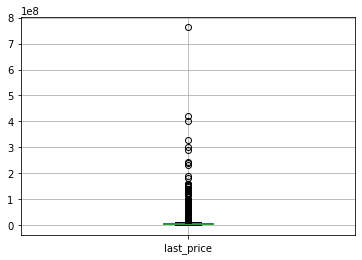

In [11]:
df.boxplot(column='last_price')

Анализ данных входящих в 1% процентили

In [12]:
df_min_price = df[df["last_price"]<1000000.0]
df_min_pr = df_min_price.groupby("last_price")["last_price"].sum()/1000000
df_min_pr.describe(percentiles = [0.01, 0.05, 0.1, .25, .50, .75])

count   55.00
mean     3.14
std      4.88
min      0.01
1%       0.24
5%       0.51
10%      0.57
25%      0.77
50%      1.00
75%      2.92
max     22.80
Name: last_price, dtype: float64

In [13]:
df_min_prc = df_min_price[["last_price", 'total_area']]
df_m = df_min_prc.copy()
df_m["price_area"] = df_m["last_price"]/df_m['total_area']
df_m[df_m["last_price"]<=440000]

,last_price,total_area,price_area
8793,12190.00,109.00,111.83
14911,430000.00,54.00,7962.96
16274,440000.00,40.00,11000.00
17456,430000.00,30.40,14144.74


In [14]:
df_max_price = df[df["last_price"]>36000000.0]
df_max_pr = df_max_price.groupby("last_price")["last_price"].sum()/1000000
df_max_pr.describe(percentiles = [0.01, .05, .9, .99])

count   156.00
mean    115.79
std     106.18
min      36.00
1%       36.61
5%       37.67
50%      77.09
90%     239.70
99%     466.25
max     763.00
Name: last_price, dtype: float64

In [15]:
df_max_pri = df_max_price[["last_price", 'total_area']]
df_max_p = df_max_pri.copy()
df_max_p["price_area"] = df_max_p["last_price"]/df_max_p['total_area']/1000
df_max_p[df_max_p["last_price"]>=239000000]

,last_price,total_area,price_area
1436,330000000.00,190.00,1736.84
12971,763000000.00,400.00,1907.50
13749,240000000.00,410.00,585.37
14706,401300000.00,401.00,1000.75
15651,300000000.00,618.00,485.44
16461,245000000.00,285.70,857.54
19540,420000000.00,900.00,466.67
22831,289238400.00,187.50,1542.60


In [16]:
df = df[df["last_price"]>12190.0]
df.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23698.00,23698.00,23698.00,23698.00,14503.00,23612.00,21795.00,23698.00,21420.00,12180.00,18156.00,18179.00,18180.00,8078.00,18180.00,9110.00,20517.00
mean,9.86,6541824.30,60.35,2.07,2.77,10.67,34.46,5.89,10.57,1.15,28793.25,14191.55,0.61,490.77,0.77,517.98,180.90
std,5.68,10887160.35,35.65,1.08,1.26,6.60,22.03,4.88,5.90,1.07,12631.10,8608.54,0.80,342.32,0.94,277.72,219.73
min,0.00,430000.00,12.00,0.00,1.00,1.00,2.00,1.00,1.30,0.00,0.00,181.00,0.00,1.00,0.00,13.00,1.00
25%,6.00,3400000.00,40.00,1.00,2.52,5.00,18.60,2.00,7.00,0.00,18584.25,9238.00,0.00,288.00,0.00,294.00,45.00
50%,9.00,4650000.00,52.00,2.00,2.65,9.00,30.00,4.00,9.10,1.00,26726.00,13099.00,0.00,455.00,1.00,502.00,95.00
75%,14.00,6800000.00,69.88,3.00,2.80,16.00,42.30,8.00,12.00,2.00,37273.50,16293.00,1.00,612.00,1.00,729.00,232.00
max,50.00,763000000.00,900.00,19.00,100.00,60.00,409.70,33.00,112.00,5.00,84869.00,65968.00,3.00,3190.00,3.00,1344.00,1580.00


Анализ цены выявил аномалии только по минимальной цене  - т.к. за 1 кв.м. 112 р быть не может. Данная аномалия исключена из датафрейма.

**2. Площадь квартиры в квадратных метрах (м²)**

<AxesSubplot:>

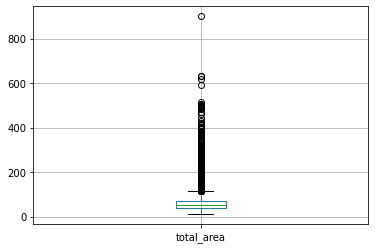

In [17]:
df.boxplot("total_area")

<AxesSubplot:>

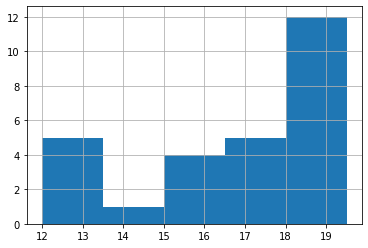

In [18]:
df_area = df[df["total_area"]<20]
df_area["total_area"].hist(bins=5)

In [19]:
df_area.groupby("is_apartment").count()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
is_apartment,,,,,,,,,,,,,,,,,,,,,
False,4,4,4,4,4,4,4,2,4,4,4,1,1,4,3,3,3,1,3,0,4
True,23,23,23,23,23,12,23,16,23,23,23,3,3,23,18,18,18,9,18,15,23


In [20]:
df_ar = df_area[df_area["is_apartment"]==False]

In [21]:
pd.crosstab(df_ar.open_plan, df_ar.studio)

studio,False,True
open_plan,,
False,3,1


В датафрейме имеются квартиры в небольшой площадью (менее 20 кв.м.), которые в основном являются апартаментами либо студиями. Исключению не подлежат.

**3. Число комнат**

In [22]:
df_rum = df[df["rooms"]==0]
df_rum.groupby("is_apartment").count()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
is_apartment,,,,,,,,,,,,,,,,,,,,,
False,6,6,6,6,6,4,6,6,6,6,6,0,5,6,2,2,2,1,2,1,6
True,191,191,191,191,191,78,188,177,191,191,191,0,121,191,116,116,116,28,116,68,177


In [23]:
df_r = df_rum[df_rum["is_apartment"]==False]
pd.crosstab(df_r.open_plan, df_r.studio)

studio,False,True
open_plan,,
False,0,5
True,1,0


Все квартиры с количеством комнат = 0, это либо апартаменты = 191 шт, либо студии = 5 шт, либо квартиры со свободной планировкой = 1 шт. Исключению не подлежат. Ошибок нет.

**4. Высота потолков(м)**

В СНиП указано, что высота потолков в жилых комнатах и кухнях должна быть не ниже - 2,5 м. Для климатических районов 1А, 1Б, 1Г, 1Д и 4А — 2,7 м. Однако высота потолка может быть уменьшена, например, за счет установки натяжных конструкций. Соответственно, все объявления с высотой потолков ниже 2.3 м из датафрейма исключаются. Также исключаются квартиры с аномально большой высотой потолка = 100 м.

In [24]:
df[df["ceiling_height"]<2.3]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
552,11,2999000.00,33.50,2017-03-30,1,2.00,15,17.50,6,True,False,False,6.50,<NA>,Санкт-Петербург,33972.00,11746.00,1,520.00,1,949.00,270
2572,4,2400000.00,62.00,2018-12-27,3,2.00,5,40.00,4,True,False,False,6.00,1,Луга,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>
4212,1,2120000.00,35.43,2017-12-18,1,2.00,18,16.60,9,True,False,False,8.80,2,Тосно,NaN,NaN,<NA>,NaN,<NA>,NaN,36
5712,5,1500000.00,42.80,2017-08-14,2,1.20,2,27.50,1,True,False,False,5.20,<NA>,городской посёлок Мга,NaN,NaN,<NA>,NaN,<NA>,NaN,248
5850,9,1650000.00,35.50,2018-05-29,1,2.00,5,NaN,5,True,False,False,NaN,<NA>,Луга,NaN,NaN,<NA>,NaN,<NA>,NaN,100
11352,4,3300000.00,36.00,2017-06-18,1,2.00,17,15.20,12,True,False,False,10.10,0,посёлок Металлострой,25268.00,26980.00,0,NaN,0,NaN,53
12755,2,1400000.00,22.50,2017-09-21,1,2.20,2,18.00,2,True,False,False,4.50,1,село Копорье,NaN,NaN,<NA>,NaN,<NA>,NaN,45
16446,6,12300000.00,88.30,2019-03-12,3,2.00,5,63.90,2,True,False,False,12.00,<NA>,Санкт-Петербург,38415.00,7675.00,1,568.00,1,154.00,<NA>
16884,0,1500000.00,33.00,2018-10-03,1,2.00,5,20.00,5,False,False,False,6.00,<NA>,Выборг,NaN,NaN,<NA>,NaN,<NA>,NaN,6
16934,5,4100000.00,40.00,2017-10-17,1,1.75,37,17.40,5,True,False,False,8.34,<NA>,Санкт-Петербург,18732.00,20444.00,0,NaN,3,80.00,71


In [25]:
df[df["ceiling_height"]==100]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
22869,0,15000000.00,25.00,2018-07-25,1,100.00,5,14.00,5,True,False,False,11.00,5,Санкт-Петербург,34963.00,8283.00,1,223.00,3,30.00,19


Прежде, чем удалить ошибки необходимо заполнить пропуски:

In [26]:
df['ceiling_height'].fillna(df['ceiling_height'].median(), inplace = True)

In [27]:
df = df[(df["ceiling_height"]>=2.3) & (df["ceiling_height"] !=100)]

In [28]:
df.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23681.00,23681.00,23681.00,23681.00,23681.00,23595.00,21780.00,23681.00,21405.00,12173.00,18150.00,18173.00,18174.00,8074.00,18174.00,9105.00,20503.00
mean,9.86,6543696.77,60.36,2.07,2.72,10.67,34.46,5.89,10.57,1.15,28792.61,14191.32,0.61,490.81,0.77,518.10,180.96
std,5.68,10890379.63,35.66,1.08,0.76,6.59,22.03,4.88,5.90,1.07,12632.56,8609.05,0.80,342.38,0.94,277.64,219.78
min,0.00,430000.00,12.00,0.00,2.30,1.00,2.00,1.00,1.30,0.00,0.00,181.00,0.00,1.00,0.00,13.00,1.00
25%,6.00,3420000.00,40.00,1.00,2.60,5.00,18.60,2.00,7.00,0.00,18582.00,9238.00,0.00,288.00,0.00,294.00,45.00
50%,9.00,4650000.00,52.00,2.00,2.65,9.00,30.00,4.00,9.10,1.00,26726.00,13099.00,0.00,455.00,1.00,502.00,95.00
75%,14.00,6800000.00,69.90,3.00,2.70,16.00,42.30,8.00,12.00,2.00,37274.50,16293.00,1.00,612.00,1.00,729.00,232.00
max,50.00,763000000.00,900.00,19.00,32.00,60.00,409.70,33.00,112.00,5.00,84869.00,65968.00,3.00,3190.00,3.00,1344.00,1580.00


Из датасета исключены ошибочные данные в количестве 17 шт. связанные с высотой потолков

**5. Жилая площадь в квадратных метрах(м²)**

Проверить площади с 2 кв.м., проверить, чтобы не было меньше чем total_area

In [29]:
df[df["living_area"]>=df["total_area"]]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
9861,10,2350000.00,25.00,2017-12-03,0,2.65,22,25.00,17,True,False,True,NaN,2,посёлок Мурино,NaN,NaN,<NA>,NaN,<NA>,NaN,13
12691,1,3700000.00,24.20,2017-11-10,0,2.65,19,24.20,13,True,False,True,NaN,1,Санкт-Петербург,17837.00,16840.00,0,NaN,2,210.00,74


Ошибок по превышению жилой площади значений общей площади в датафрейме нет. есть квартиры где жилая площадь равна общей, но так как данные квартиры относятся к апартаментам, то исключению из датафрейма они не подлежат.

В России есть санитарная норма относительно жилой площади - 6 кв. м на человека. Т.о. все квартиры с жилой площадью менее 6 кв.м. исключаются из датафрейма.

In [30]:
df[df["living_area"]<6.0]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3242,7,4440000.00,41.00,2017-07-02,1,2.65,17,3.00,17,True,False,False,11.00,<NA>,Санкт-Петербург,19272.00,13073.00,0,NaN,0,NaN,216
13915,20,6350000.00,52.00,2018-02-06,2,3.00,6,2.00,2,True,False,False,9.00,<NA>,Санкт-Петербург,32453.00,6521.00,0,NaN,1,1012.00,91
17582,11,2680000.00,22.00,2018-08-11,0,2.65,25,5.00,8,True,True,False,NaN,2,Санкт-Петербург,22735.00,11618.00,1,835.00,1,652.00,70
21758,0,2330000.00,23.00,2018-01-01,0,2.65,24,2.00,22,True,True,False,NaN,<NA>,посёлок Мурино,NaN,NaN,<NA>,NaN,<NA>,NaN,66
21943,15,6100000.00,77.60,2019-02-28,4,2.50,9,5.40,1,True,False,False,9.80,<NA>,Санкт-Петербург,29338.00,11270.00,1,584.00,0,NaN,33
23574,14,64990000.00,139.00,2015-11-24,3,3.00,8,3.00,8,True,False,False,16.00,1,Санкт-Петербург,33255.00,5975.00,1,630.00,3,100.00,280


In [31]:
df = df[(df["living_area"]!=2.0) & (df["living_area"]!=3.0) & (df["living_area"]!=5.0) & (df["living_area"]!=5.4)]

In [32]:
df.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23675.00,23675.00,23675.00,23675.00,23675.00,23589.00,21774.00,23675.00,21401.00,12171.00,18145.00,18168.00,18169.00,8071.00,18169.00,9102.00,20497.00
mean,9.86,6541685.03,60.36,2.07,2.72,10.67,34.47,5.89,10.57,1.15,28792.99,14192.56,0.61,490.74,0.77,518.08,180.97
std,5.68,10885061.02,35.66,1.08,0.76,6.59,22.03,4.88,5.90,1.07,12633.95,8609.78,0.80,342.42,0.94,277.60,219.80
min,0.00,430000.00,12.00,0.00,2.30,1.00,6.00,1.00,1.30,0.00,0.00,181.00,0.00,1.00,0.00,13.00,1.00
25%,6.00,3420000.00,40.00,1.00,2.60,5.00,18.60,2.00,7.00,0.00,18578.00,9238.00,0.00,288.00,0.00,294.00,45.00
50%,9.00,4650000.00,52.00,2.00,2.65,9.00,30.00,4.00,9.10,1.00,26726.00,13101.00,0.00,454.00,1.00,502.00,95.00
75%,14.00,6800000.00,69.90,3.00,2.70,16.00,42.30,8.00,12.00,2.00,37277.00,16293.00,1.00,612.00,1.00,729.00,232.00
max,50.00,763000000.00,900.00,19.00,32.00,60.00,409.70,33.00,112.00,5.00,84869.00,65968.00,3.00,3190.00,3.00,1344.00,1580.00


Из данных исключены 6 квартир, где жилая площадь не соответствует санитарным нормам.

**6. Этаж**

 Проверить на соответсвие с floors_total, чтобы не было больше

In [33]:
df[df["floor"]>df["floors_total"]]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


Ошибок нет

**7. Квартира-студия**

Проверить с rooms в студии не должно быть больше 1 комнаты

In [34]:
df_stud = df[df["studio"]==True]
df_stud[df_stud["rooms"]!=0]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
2389,5,2250000.00,25.41,2016-06-07,1,2.65,12,17.08,8,False,True,False,NaN,2,Санкт-Петербург,14125.00,12921.00,2,328.00,2,485.00,26
3187,13,3800000.00,27.00,2016-05-17,1,2.65,14,18.00,8,False,True,False,NaN,2,Санкт-Петербург,50348.00,16053.00,0,NaN,0,NaN,45
4180,4,4500000.00,34.00,2016-04-25,1,2.80,10,21.00,10,False,True,False,NaN,2,Санкт-Петербург,23609.00,5299.00,0,NaN,1,433.00,62
8683,10,3500000.00,32.50,2016-05-05,1,3.00,23,29.90,11,False,True,False,NaN,2,Санкт-Петербург,34967.00,14640.00,0,NaN,1,564.00,45
11026,1,2800000.00,28.00,2016-05-04,1,2.65,26,19.00,6,False,True,False,NaN,2,посёлок Парголово,53511.00,19687.00,0,NaN,0,NaN,45
12935,10,2200000.00,31.00,2016-05-15,1,2.50,8,22.30,5,False,True,False,NaN,1,Никольское,NaN,NaN,<NA>,NaN,<NA>,NaN,44
15142,2,2700000.00,30.00,2016-05-10,1,2.65,21,26.00,6,False,True,False,NaN,0,деревня Кудрово,NaN,NaN,<NA>,NaN,<NA>,NaN,55
18732,4,2400000.00,22.00,2016-05-06,1,2.65,10,15.00,6,True,True,False,NaN,0,деревня Кудрово,NaN,NaN,<NA>,NaN,<NA>,NaN,45
20086,0,1550000.00,22.00,2016-05-11,1,2.70,15,10.94,14,False,True,False,NaN,2,Никольское,NaN,NaN,<NA>,NaN,<NA>,NaN,45
21702,9,2349000.00,23.40,2016-05-19,1,2.70,20,16.00,8,False,True,False,NaN,1,деревня Новое Девяткино,NaN,NaN,<NA>,NaN,<NA>,NaN,34


Ошибок не обнаружено

**8. Площадь кухни в квадратных метрах (м²)**

Проверить min и  max значение

In [35]:
df[df["kitchen_area"] ==1.3]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
20217,7,4250000.00,28.50,2019-05-01,1,2.80,14,19.50,10,True,False,False,1.30,<NA>,Санкт-Петербург,37199.00,12721.00,0,NaN,0,NaN,<NA>


In [36]:
df_kitch = df[df["kitchen_area"] < 4.0 ]

In [37]:
pd.crosstab(df_kitch.is_apartment , df_kitch.studio)

studio,False
is_apartment,
False,3
True,26


In [38]:
pd.crosstab(df_kitch.is_apartment, df_kitch.open_plan)

open_plan,False
is_apartment,
False,3
True,26


In [39]:
df_kitch[df_kitch["is_apartment"]==False]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
7950,3,5967734.00,66.40,2017-02-07,2,2.65,4,44.40,2,False,False,False,2.89,<NA>,Санкт-Петербург,44870.00,20802.00,0,NaN,0,NaN,335
10208,3,1900000.00,17.00,2018-08-14,1,2.75,4,13.00,2,False,False,False,3.00,<NA>,Санкт-Петербург,25072.00,5639.00,0,NaN,0,NaN,7
23498,7,1600000.00,54.00,2016-12-26,2,2.30,1,33.00,1,False,False,False,3.50,0,Высоцк,NaN,NaN,<NA>,NaN,<NA>,NaN,281


Квартиры с маленькими кухнями (менее 4 кв.м.) в большинстве являются апартаментами (26 квартир), у остальных трех квартир площадь кухонь составляет от 2.89 до 3.5 кв. м., что может быть у квартир старой постройки. Ошибок не обнаружено.

**9. Расстояние до ближайшего аэропорта в метрах (м)**

Проверить нулевые значения

In [40]:
df[df["airports_nearest"]==0]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
21085,0,7000000.00,34.70,2018-09-23,1,2.70,9,19.80,3,True,False,False,6.00,2,Санкт-Петербург,0.00,22801.00,0,NaN,0,NaN,60


In [41]:
df=df[df["airports_nearest"]!=0]

In [42]:
df.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23674.00,23674.00,23674.00,23674.00,23674.00,23588.00,21773.00,23674.00,21400.00,12170.00,18144.00,18167.00,18168.00,8071.00,18168.00,9102.00,20496.00
mean,9.86,6541665.67,60.36,2.07,2.72,10.67,34.47,5.89,10.57,1.15,28794.58,14192.09,0.61,490.74,0.77,518.08,180.98
std,5.68,10885290.52,35.66,1.08,0.76,6.59,22.03,4.88,5.90,1.07,12632.49,8609.78,0.80,342.42,0.94,277.60,219.81
min,0.00,430000.00,12.00,0.00,2.30,1.00,6.00,1.00,1.30,0.00,6450.00,181.00,0.00,1.00,0.00,13.00,1.00
25%,6.00,3420000.00,40.00,1.00,2.60,5.00,18.60,2.00,7.00,0.00,18581.00,9238.00,0.00,288.00,0.00,294.00,45.00
50%,9.00,4650000.00,52.00,2.00,2.65,9.00,30.00,4.00,9.10,1.00,26726.00,13101.00,0.00,454.00,1.00,502.00,95.00
75%,14.00,6800000.00,69.90,3.00,2.70,16.00,42.30,8.00,12.00,2.00,37278.75,16293.00,1.00,612.00,1.00,729.00,232.00
max,50.00,763000000.00,900.00,19.00,32.00,60.00,409.70,33.00,112.00,5.00,84869.00,65968.00,3.00,3190.00,3.00,1344.00,1580.00


Из данных исключена 1 квартира расположенная на территории здания аэропорта ("airports_nearest"==0).

**10. Расстояние до центра города (м)**

Проверить max

In [43]:
df[df["cityCenters_nearest"]==65968.0]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
9640,8,4200000.00,51.40,2014-12-10,2,2.55,5,31.00,2,True,False,False,6.00,1,посёлок Молодёжное,84869.00,65968.00,0,NaN,0,NaN,1194


Квартира с наибольшей удаленностью от центра города, находиться в поселке

**11. Расстояние до ближайшего парка (м)**

Необходимо проверить на соответсвие с parks_around3000

In [44]:
df_park=df[df["parks_around3000"]==0]
pd.crosstab(df_park.parks_nearest, df_park.parks_around3000)

parks_around3000,0
parks_nearest,
3013.00,1
3064.00,1
3190.00,2


Ошибок не обнаружено

**12. Расстояние до ближайшего водоёма (м)**

 Необходимо проверить на соответствие с ponds_around3000

In [45]:
df_park=df[df["ponds_around3000"]==0]
pd.crosstab(df_park.ponds_nearest, df_park.ponds_around3000)

ponds_around3000
ponds_nearest


Ошибок не обнаружено

***Выводы по результатам анализа данных на ошибки:***

При анализе данных было выявлено ряд ошибок по ценам, высоте потолков, жилой площади и удаленности от аэропорта. Всего по результатам анализа было исключено 25 объявлений.


## $\checkmark$ Работа с выбросами и аномалиями

In [46]:
int_var = ["last_price", "total_area", "living_area", "kitchen_area"]

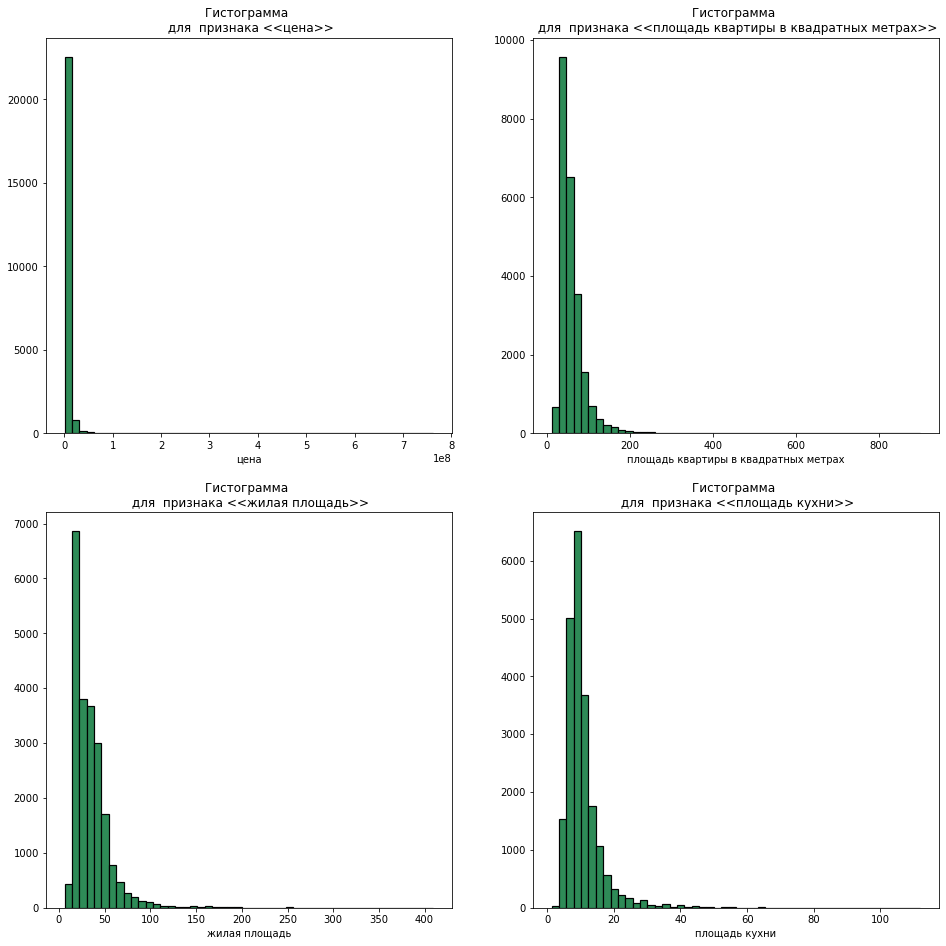

In [47]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(16,16))
i = 0
l = 0
j = 0
for i in range(2):
    for j in range(2):
        axes[i, j].hist(df[int_var[l]], bins = 50, color = "seagreen", edgecolor='black', linewidth=1.2)
        axes[i, j].set_title("Гистограмма \n для  признака <<{}>>".format(dict_to_rus[int_var[l]]))
        axes[i, j].set_xlabel(dict_to_rus[int_var[l]])
        l+=1

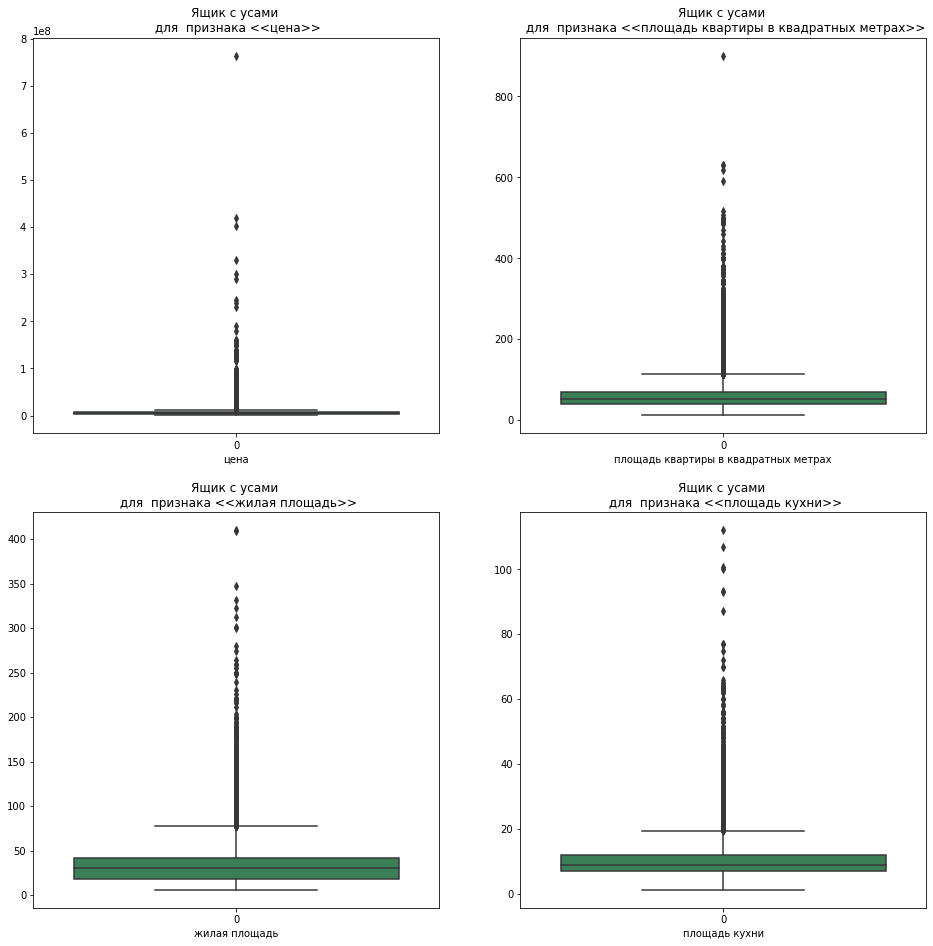

In [48]:
fig, axes = plt.subplots(2, 2, figsize=(16,16))
for i, col in enumerate(int_var):
    plt.subplot(2,2,i+1)
    sns.boxplot(data=df[col], whis = 1.5, color = "seagreen")
    plt.title("Ящик с усами \n для  признака <<{}>>".format(dict_to_rus[col]))
    plt.xlabel(dict_to_rus[col])

Очистка от аномальных  значений c помощью правила сигм:

In [49]:
df[["last_price","total_area", "kitchen_area"]].describe(percentiles= [0.0028, 0.0045, 0.9544, 0.99, 0.9972])

,last_price,total_area,kitchen_area
count,23674.00,23674.00,21400.00
mean,6541665.67,60.36,10.57
std,10885290.52,35.66,5.90
min,430000.00,12.00,1.30
0.3%,690000.00,22.00,4.29
0.4%,780000.00,23.30,4.90
50%,4650000.00,52.00,9.10
95.4%,16000000.00,120.00,20.82
99%,36000000.00,197.39,35.05
99.7%,76314557.20,293.20,48.56


In [50]:
df_clients = df[(df.last_price>780000.00)& (df.last_price<16000000.00) & 
                (df.total_area>23.30)& (df.total_area<120.00) & 
                (df.kitchen_area>4.90)& (df.kitchen_area<20.82)]

In [51]:
sh_old = df.shape[0]
sh_new = df_clients.shape[0]
print('Количество аномальных наблюдений {:d}, что составляет {:.2%} от общего числа записей.'
      .format(sh_old-sh_new, (sh_old-sh_new)/sh_old))

Количество аномальных наблюдений 4263, что составляет 18.01% от общего числа записей.


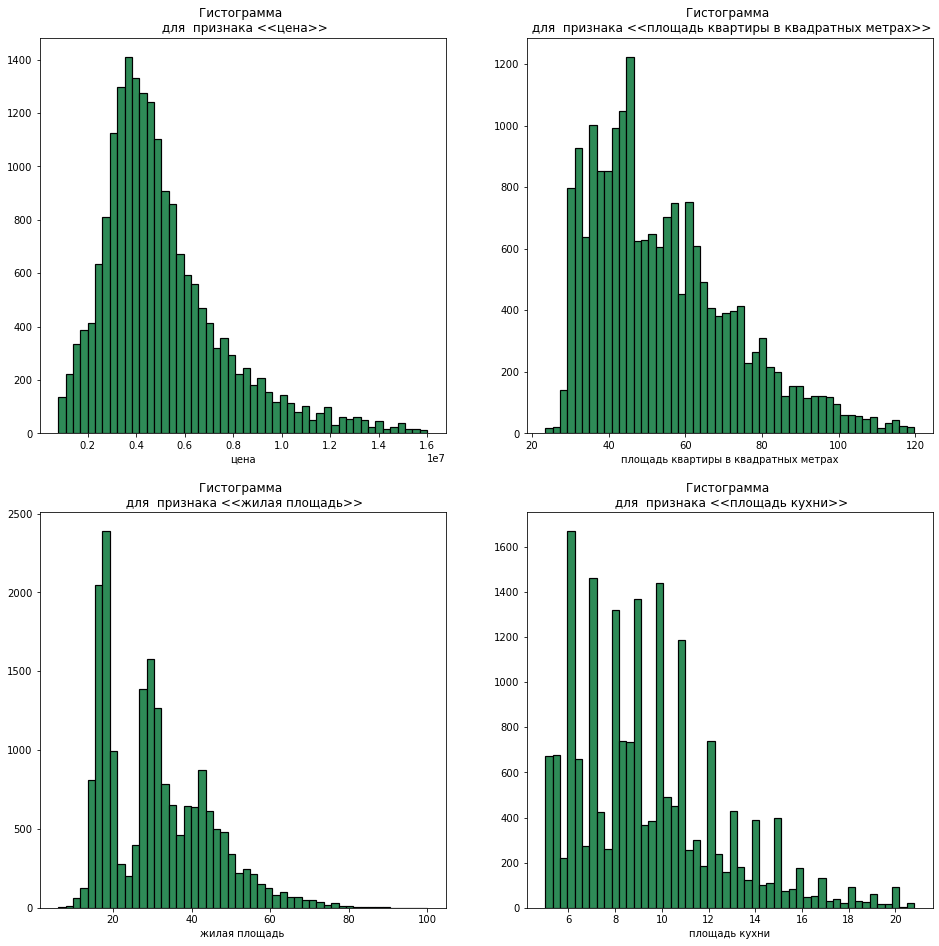

In [52]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(16,16))
i = 0
l = 0
j = 0
for i in range(2):
    for j in range(2):
        axes[i, j].hist(df_clients[int_var[l]], bins = 50, color = "seagreen", edgecolor='black', linewidth=1.2)
        axes[i, j].set_title("Гистограмма \n для  признака <<{}>>".format(dict_to_rus[int_var[l]]))
        axes[i, j].set_xlabel(dict_to_rus[int_var[l]])
        l+=1

In [53]:
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19411 entries, 1 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          19411 non-null  int64         
 1   last_price            19411 non-null  float64       
 2   total_area            19411 non-null  float64       
 3   first_day_exposition  19411 non-null  datetime64[ns]
 4   rooms                 19411 non-null  int64         
 5   ceiling_height        19411 non-null  float64       
 6   floors_total          19378 non-null  Int64         
 7   living_area           19048 non-null  float64       
 8   floor                 19411 non-null  int64         
 9   is_apartment          19411 non-null  bool          
 10  studio                19411 non-null  bool          
 11  open_plan             19411 non-null  bool          
 12  kitchen_area          19411 non-null  float64       
 13  balcony         

**Выводы по результатам анализа аномальных значений:**

Проверка по аномальным данным и исключение аномалий производилось с помощью метода сигм и только по критичным для анализа данным - цена и площадь. В результате анализа выявлено и исключено из дальнейшего анализа  4 263  аномальных наблюдений , что составляет 18.01% от общего числа записей.


## $\checkmark$ Работа с пропущенными значениями

In [54]:
df_clients.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               33
living_area               363
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                  8898
locality_name              33
airports_nearest         4579
cityCenters_nearest      4565
parks_around3000         4564
parks_nearest           13131
ponds_around3000         4564
ponds_nearest           12315
days_exposition          2495
dtype: int64

**1. Локация**

Так, как в признаке locality_name пропущено 33 единицы, данные пропуски  было решено исключить из датафрейма, т.к. корректно заполнить пропущенные данные не представляется возможным.

In [55]:
df_clients = df_clients.dropna(subset = ['locality_name'])

In [56]:
print('Количество пропусков в столбце "Наименование населенного пункта" после заполнения равно: {}'.format(df_clients['locality_name'].isna().sum()))

Количество пропусков в столбце "Наименование населенного пункта" после заполнения равно: 0


**2. Общее количество этажей**

In [57]:
df_clients[df_clients["floors_total"].isnull()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
186,12,11640000.00,65.20,2018-10-02,2,2.65,<NA>,30.80,4,True,False,False,12.00,<NA>,Санкт-Петербург,39197.00,12373.00,1,123.00,0,NaN,49
457,4,9788348.00,70.80,2015-08-01,2,2.65,<NA>,38.40,12,True,False,False,10.63,0,Санкт-Петербург,37364.00,8322.00,2,309.00,2,706.00,727
671,4,6051191.00,93.60,2017-04-06,3,2.65,<NA>,47.10,8,True,False,False,16.80,0,Санкт-Петербург,22041.00,17369.00,0,NaN,1,374.00,123
2392,7,5395770.00,53.00,2017-06-29,2,2.65,<NA>,29.00,22,True,False,False,9.00,0,Санкт-Петербург,43074.00,10820.00,0,NaN,0,NaN,48
2952,10,6500000.00,54.30,2019-04-23,1,2.65,<NA>,22.20,6,True,False,False,12.30,<NA>,Санкт-Петербург,23606.00,3148.00,0,NaN,0,NaN,<NA>
3031,9,6400000.00,56.70,2018-03-27,2,2.65,<NA>,32.00,12,True,False,False,12.00,<NA>,Кудрово,NaN,NaN,<NA>,NaN,<NA>,NaN,231
3438,10,4100000.00,38.00,2018-04-14,1,2.65,<NA>,19.00,12,True,False,False,10.30,<NA>,Кудрово,NaN,NaN,<NA>,NaN,<NA>,NaN,95
4140,4,10296437.00,100.30,2017-07-02,3,2.65,<NA>,58.18,3,True,False,False,10.90,0,Санкт-Петербург,37364.00,8322.00,2,309.00,2,706.00,35
4617,4,4275062.00,61.20,2017-04-27,2,2.65,<NA>,32.00,12,True,False,False,12.20,0,Санкт-Петербург,22041.00,17369.00,0,NaN,1,374.00,72
5784,4,4262941.00,59.90,2017-04-02,2,2.65,<NA>,31.70,18,True,False,False,11.90,0,Санкт-Петербург,22041.00,17369.00,0,NaN,1,374.00,127


In [58]:
df_clients["floors_total"].describe()

count   19346.00
mean       10.74
std         6.55
min         1.00
25%         5.00
50%         9.00
75%        16.00
max        60.00
Name: floors_total, dtype: float64

Так, как пропущенных значений по показателю floors_total составляет 33 единицы  - заменяем пропущенное количество этажей на максимальное значение, чтобы в дальнейшем при анализе цен в зависимости от этажности данные квартиры попали в среднюю выборку не повлияли на результаты анализа.

In [59]:
df_clients["floors_total"].fillna(df_clients["floors_total"].max(), inplace = True)

In [60]:
print("Количество этажей с пропущенными значениями равно:{}".format(df_clients["floors_total"].isna().sum()))

Количество этажей с пропущенными значениями равно:0


**3. Жилая площадь**

Для заполнения пропущенных значений в жилой площади использовался коэффициент который рассчитывался как жилая площадь деленная на общую

In [61]:
df_clients["kof"] = (df_clients["living_area"]/df_clients["total_area"])
df_clients["kof"].describe()

count   19015.00
mean        0.56
std         0.10
min         0.14
25%         0.50
50%         0.57
75%         0.63
max         0.98
Name: kof, dtype: float64

In [62]:
df_clients["living_area"].fillna((df_clients["total_area"]*df_clients["kof"].mean()), inplace = True)

In [63]:
print("Жилая площадь с пропущенными значениями равно:{}".format(df_clients["living_area"].isna().sum()))

Жилая площадь с пропущенными значениями равно:0


In [64]:
df_clients.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                  8896
locality_name               0
airports_nearest         4575
cityCenters_nearest      4561
parks_around3000         4560
parks_nearest           13108
ponds_around3000         4560
ponds_nearest           12300
days_exposition          2494
kof                       363
dtype: int64

d:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


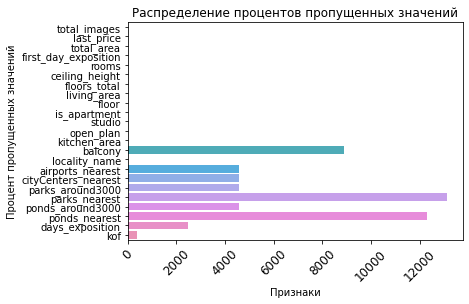

In [65]:
miss_val = pd.DataFrame((df_clients.isna().sum())).reset_index()
ax = sns.barplot(0,'index', data = miss_val)
plt.xticks(rotation = 45,fontsize = 12);
plt.title("Распределение процентов пропущенных значений");
plt.ylabel("Процент пропущенных значений");
plt.xlabel("Признаки");

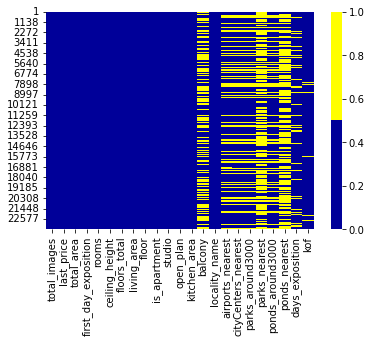

In [66]:
colors = ['#000099', '#ffff00'] # желтый - пропущенные данные, синий - не пропущенные
sns.heatmap(df_clients.isnull(), cmap=sns.color_palette(colors));

**Выводы по результатам работы по заполнению пропусков:**

В данных были заполнены столбцы: Общее количество этажей (33 штк.)  и Жилая площадь (363 штк). Пропущенные значения по столбцу локация были исключены из датафрейма (33 штк). Ранее, при обработке аномальных значений, в данных по высоте потолков были заполнены пропущенные значения  показателем медиана (9 195 штк). 

В датафрейме остались столбцы с пропущенными значениями, которые невозможно корректно заполнить, так, чтобы они не повлияли на результаты анализа. При необходимости, при детальном анализе с использованием данных столбцов, пропущенные значения будут исключены из данных.


## $\checkmark$  EDA анализ

Перед началом анализа посчитаем и добавим в таблицу ряд значений

**1. Цену квадратного метра**

In [67]:
df_clients["price_mln"] = df_clients["last_price"]/df_clients["total_area"]

**2. День недели, месяц и год публикации объявления**

In [68]:
df_clients["w_day"] = df_clients["first_day_exposition"].dt.weekday
df_clients["w_month"] = df_clients["first_day_exposition"].dt.month
df_clients["w_year"] = df_clients["first_day_exposition"].dt.year

In [69]:
df_clients.head(2)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kof,price_mln,w_day,w_month,w_year
1,7,3350000.00,40.40,2018-12-04,1,2.65,11,18.60,1,True,False,False,11.00,2,посёлок Шушары,12817.00,18603.00,0,NaN,0,NaN,81,0.46,82920.79,1,12,2018
2,10,5196000.00,56.00,2015-08-20,2,2.65,5,34.30,4,True,False,False,8.30,0,Санкт-Петербург,21741.00,13933.00,1,90.00,2,574.00,558,0.61,92785.71,3,8,2015


**3. Этаж квартиры; варианты — первый, последний, другой**

In [70]:
def flor(x):
    if x["floor"] == 1:
        return "Первый"
    elif x["floor"] == x["floors_total"]:
        return "Последний"
    else:
        return "Другой"

In [71]:
df_clients['floor_type'] = df_clients.apply(flor, axis=1)

In [72]:
df_clients.head(2)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kof,price_mln,w_day,w_month,w_year,floor_type
1,7,3350000.00,40.40,2018-12-04,1,2.65,11,18.60,1,True,False,False,11.00,2,посёлок Шушары,12817.00,18603.00,0,NaN,0,NaN,81,0.46,82920.79,1,12,2018,Первый
2,10,5196000.00,56.00,2015-08-20,2,2.65,5,34.30,4,True,False,False,8.30,0,Санкт-Петербург,21741.00,13933.00,1,90.00,2,574.00,558,0.61,92785.71,3,8,2015,Другой


**4. Соотношение жилой и общей площади, а также отношение площади кухни к общей.**

In [73]:
df_clients["liv_tot_area"] = df_clients["living_area"]/df_clients["total_area"]
df_clients["kit_tot_area"] = df_clients["kitchen_area"]/df_clients["total_area"]

In [74]:
df_clients.head(2)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kof,price_mln,w_day,w_month,w_year,floor_type,liv_tot_area,kit_tot_area
1,7,3350000.00,40.40,2018-12-04,1,2.65,11,18.60,1,True,False,False,11.00,2,посёлок Шушары,12817.00,18603.00,0,NaN,0,NaN,81,0.46,82920.79,1,12,2018,Первый,0.46,0.27
2,10,5196000.00,56.00,2015-08-20,2,2.65,5,34.30,4,True,False,False,8.30,0,Санкт-Петербург,21741.00,13933.00,1,90.00,2,574.00,558,0.61,92785.71,3,8,2015,Другой,0.61,0.15


## $\checkmark$ Исследовательский анализ данных

**1. Изучите следующие параметры: площадь, цена, число комнат, высота потолков. Постройте гистограммы для каждого параметра.**

In [75]:
df_clients[["total_area", "last_price", "rooms", "ceiling_height"]].describe()

,total_area,last_price,rooms,ceiling_height
count,19378.00,19378.00,19378.00,19378.00
mean,54.14,5082031.16,1.97,2.70
std,18.52,2521210.18,0.89,0.75
min,23.40,790000.00,1.00,2.30
25%,40.00,3400000.00,1.00,2.60
50%,50.00,4500000.00,2.00,2.65
75%,64.90,6150000.00,3.00,2.70
max,119.70,15990000.00,6.00,32.00


In [76]:
int_v = ["total_area", "last_price", "rooms", "ceiling_height"]

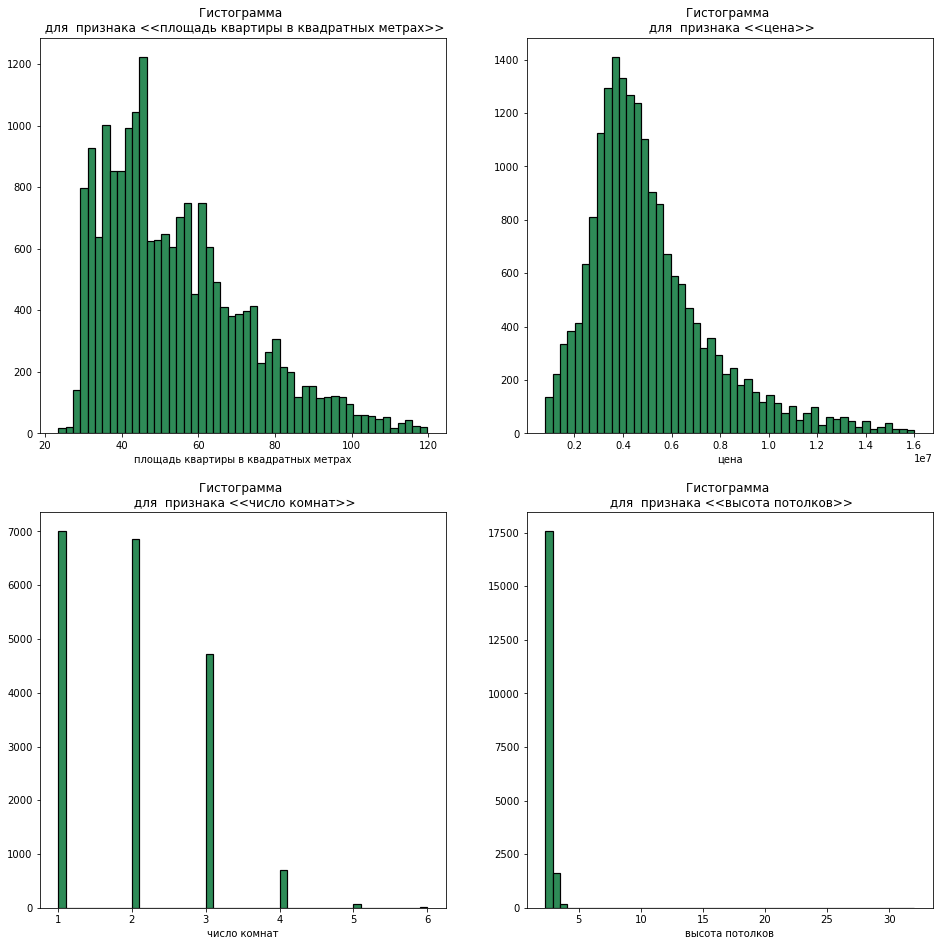

In [77]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(16,16))
i = 0
l = 0
j = 0
for i in range(2):
    for j in range(2):
        axes[i, j].hist(df_clients[int_v[l]], bins = 50, color = "seagreen", edgecolor='black', linewidth=1.2)
        axes[i, j].set_title("Гистограмма \n для  признака <<{}>>".format(dict_to_rus[int_v[l]]))
        axes[i, j].set_xlabel(dict_to_rus[int_v[l]])
        l+=1

array([<AxesSubplot:xlabel='total_area'>], dtype=object)

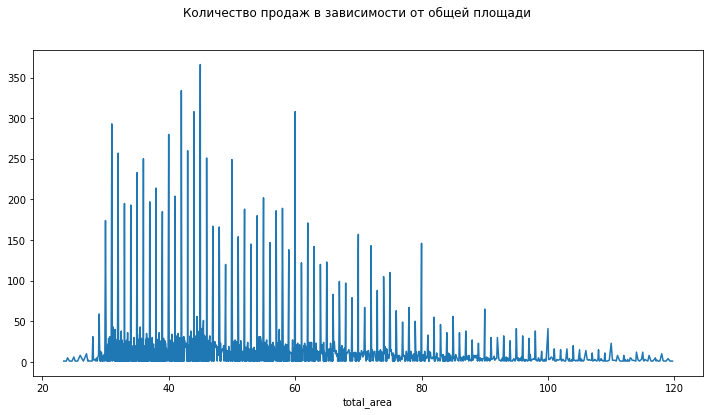

In [78]:
df_cl = df_clients.groupby(["total_area"])["last_price"].count()
df_cl.plot(title ="Количество продаж в зависимости от общей площади", kind='line', subplots=True, figsize=(12, 6), sharex = False, sharey = False)

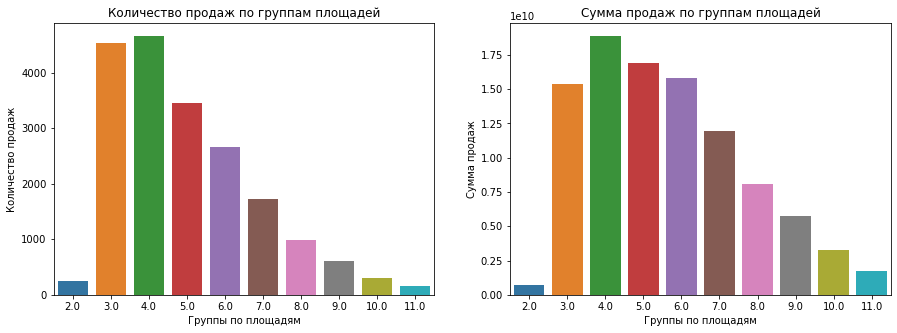

In [79]:
df_cl_ar = df_clients[["total_area", "last_price", "rooms", "ceiling_height"]]
df_cl_ar2 = df_cl_ar.copy()
df_cl_ar2["area_grp"] =df_cl_ar2["total_area"]//10

fig, ax = plt.subplots(1, 2, figsize = (15,5))
plt.subplot(121)

fr = df_cl_ar2.pivot_table(index = "area_grp", values = "last_price", aggfunc = "count").sort_values(by = "last_price", ascending = False)
fr = fr.reset_index().rename_axis(None, axis=1)
plt.title('Количество продаж по группам площадей')
sns.barplot(data=fr, x='area_grp', y='last_price')
plt.xlabel('Группы по площадям')
plt.ylabel('Количество продаж');

plt.subplot(122)
fr2 = df_cl_ar2.pivot_table(index = "area_grp", values = "last_price", aggfunc = "sum").sort_values(by = "last_price", ascending = False)
fr2 = fr2.reset_index().rename_axis(None, axis=1)
plt.title('Сумма продаж по группам площадей')
sns.barplot(data=fr2, x='area_grp', y='last_price')
plt.xlabel('Группы по площадям')
plt.ylabel('Сумма продаж');

Анализ количества продаж от Общей площади показал, что больше всех продаются квартиры с площадью от 40 до 50 кв.м., 
 - На втором месте  - квартиры с площадями от 30 до 40 кв.м.
 - На третьем - квартиры с площадями от 50 до 60 кв.м.
По общей сумме продаж мы видем, что квартиры с площадью от 40 до 50 кв.м. так-же приобладают в анализируемых данных
 

In [80]:
df_cl_ar2
df_cl_ar2.groupby(['area_grp', 'rooms'])['last_price'].count()

area_grp  rooms
2.00      1         255
          2           2
3.00      1        4450
          2          88
4.00      1        1999
          2        2493
          3         109
          4          62
          5           1
5.00      1         241
          2        2370
          3         837
          4          16
6.00      1          43
          2        1264
          3        1303
          4          47
          5           3
7.00      1           5
          2         454
          3        1103
          4         164
          5           1
8.00      1           7
          2         144
          3         725
          4         107
          5           7
          6           1
9.00      1           1
          2          36
          3         419
          4         138
          5          13
          6           2
10.00     1           2
          2          11
          3         176
          4          95
          5          22
          6           1


**Вывод :  Наиболее распространенными являются 1 и 2 комнатные квартиры c общей площадью от 30 до 50 кв.м. включительно и со средней высотой потолка 2.65 м.**

**2. Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану.**

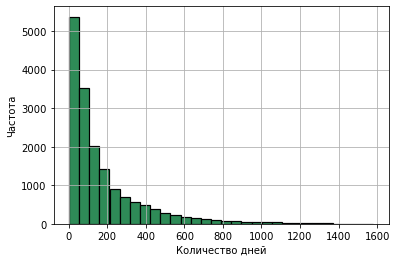

In [81]:
df_clients['days_exposition'].hist(bins=30, color = "seagreen", edgecolor='black', linewidth=1.2)
plt.xlabel('Количество дней')
plt.ylabel('Частота') 
plt.show()

In [82]:
df_clients['days_exposition'].describe()

count   16884.00
mean      178.79
std       215.84
min         1.00
25%        43.00
50%        97.00
75%       229.00
max      1580.00
Name: days_exposition, dtype: float64

In [83]:
df_clients.pivot_table(index = "days_exposition", values = "last_price", aggfunc = "count").sort_values(by = "last_price")

,last_price
days_exposition,
1,1
922,1
920,1
914,1
912,1
...,...
4,152
30,185
7,204


**Вывод: Больше всего квартир продавалось на 45 день (522 шт), минимальное количество дней за которые продалась квартира -  1 день с момента публикации объявления, максимальное - 1 580 дней. В среднем квартиры продаются за 97 дней  или 3 месяца с момента подачи объявления. Анализ гистограммы показал, что чаще квартиры продаются за период 53 дня с момента подачи объявления.**

**3. Какие факторы больше всего влияют на стоимость квартиры.**

**3.1. Изучите, зависит ли цена от площади, числа комнат, удалённости от центра.**

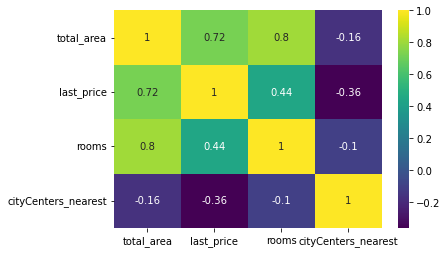

In [84]:
voz = df_clients[["total_area", "last_price", "rooms", "cityCenters_nearest"]]
corr = voz.corr()
sns.heatmap(corr, cmap="viridis", annot = True);

Анализ корреляции выявил выявил прямую и высокую зависимость стоимости квартиры от общей площади.

Text(0, 0.5, 'Цена')

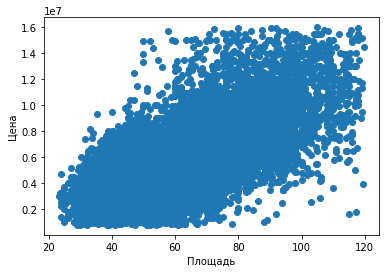

In [85]:
plt.scatter(x = df_clients['total_area'], y = df_clients['last_price'])
plt.xlabel('Площадь')
plt.ylabel('Цена')

Text(0, 0.5, 'Цена')

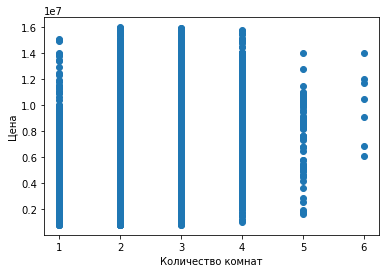

In [86]:
plt.scatter(x = df_clients['rooms'], y = df_clients['last_price'])
plt.xlabel('Количество комнат')
plt.ylabel('Цена')

Text(0, 0.5, 'Средняя цена за 1 кв.м.')

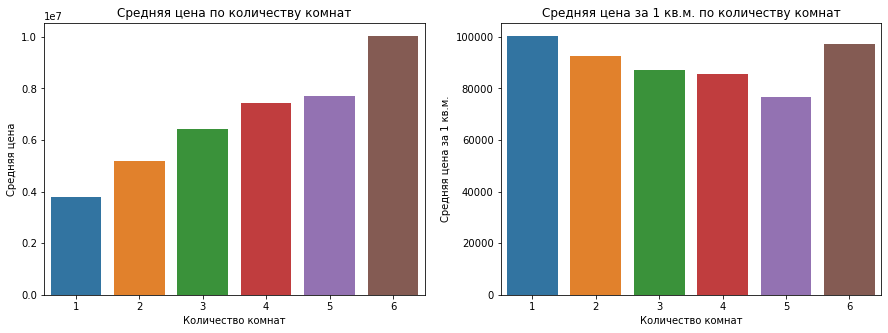

In [87]:
fig, ax = plt.subplots(1, 2, figsize = (15,5))
plt.subplot(121)
h = df_clients.pivot_table(index = "rooms", values= "last_price", aggfunc='mean').sort_values(by='last_price', ascending=False)
h = h.reset_index().rename_axis(None, axis=1)
plt.title('Средняя цена по количеству комнат')
sns.barplot(data=h, x='rooms', y='last_price')
plt.xlabel('Количество комнат')

plt.ylabel('Средняя цена');
plt.subplot(122)
h2 = df_clients.pivot_table(index = "rooms", values= "price_mln", aggfunc='mean').sort_values(by='price_mln', ascending=False)
h2 = h2.reset_index().rename_axis(None, axis=1)
plt.title('Средняя цена за 1 кв.м. по количеству комнат')
sns.barplot(data=h2, x='rooms', y='price_mln')
plt.xlabel('Количество комнат')
plt.ylabel('Средняя цена за 1 кв.м.')

In [88]:
df_clients['last_price'].corr(df_clients['rooms'])

0.4444120548501514

Анализ изменения цены от количества комнат показал, что  чем больше комнат,  тем выше средняя цена за квартиру, при этом наблюдается снижение стоимости за 1 кв.м. при росте числа комнат, что не касается квартир с количеством комнат  равное 6, предположительно, в связи с тем, что данные квартиры относится к категории элитное жилье.

Text(0, 0.5, 'Цена')

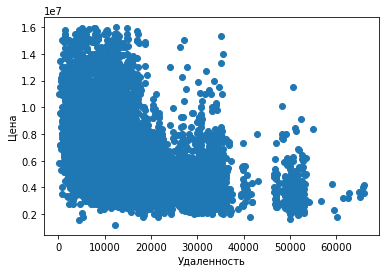

In [89]:
plt.scatter(x = df_clients['cityCenters_nearest'], y = df_clients['last_price'])
plt.xlabel('Удаленность')
plt.ylabel('Цена')

**Вывод: Согласно проведенному анализу, можно сделать вывод, что цена напрямую зависит от площади и количества комнат, когда как удаленность от центра города имеет отрицательную корреляцию с ценой, что говорит о том, что  чем квартира дальше от центра города, тем дешевле она стоит.**

**3.2. Изучите зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом.**

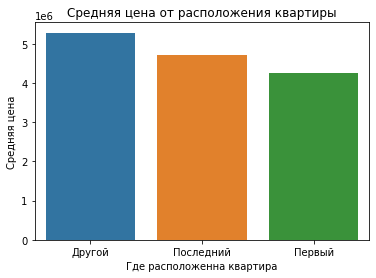

In [90]:
h = df_clients.pivot_table(index = "floor_type", values= "last_price", aggfunc='mean').sort_values(by='last_price', ascending=False)
h = h.reset_index().rename_axis(None, axis=1)
plt.title('Средняя цена от расположения квартиры')
sns.barplot(data=h, x='floor_type', y='last_price')
plt.xlabel('Где расположенна квартира')
plt.ylabel('Средняя цена');

**Вывод: Стоимость квартиры  зависит от того, на каком этаже находится квартира - средняя цена на квартиры расположенные между вторым и предпоследним этажом выше, чем те, которые находятся на первом и последнем этаже. Самые дешевые квартиры располагаются на первом этаже.**

**3.3. Изучите зависимость от даты размещения: дня недели, месяца и года.**

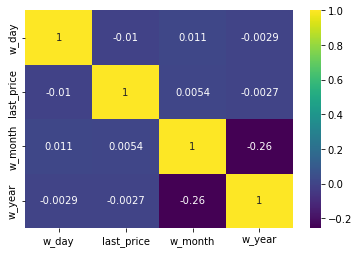

In [91]:
voz2 = df_clients[["w_day", "last_price", "w_month", "w_year"]]
corr = voz2.corr()
sns.heatmap(corr, cmap="viridis", annot = True);

**Вывод: цена квартиры никак не зависит от дня недели, месяца или года когда было опубликовано объявление.**

**4. Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите среди них населённые пункты с самой высокой и низкой стоимостью жилья.**

In [92]:
top_10 = df_clients.groupby(["locality_name"])["last_price"].count().sort_values(ascending = False)
top_10 = top_10.head(10)
top_10

locality_name
Санкт-Петербург      12674
посёлок Мурино         417
посёлок Шушары         391
Всеволожск             346
Колпино                316
Пушкин                 299
посёлок Парголово      287
Гатчина                283
деревня Кудрово        221
Петергоф               185
Name: last_price, dtype: int64

In [93]:
loc_top = (["Санкт-Петербург", "посёлок Мурино", "посёлок Шушары", "Всеволожск", "Колпино", "Пушкин", "посёлок Парголово", "Гатчина", "деревня Кудрово", "Петергоф"])

<AxesSubplot:xlabel='locality_name'>

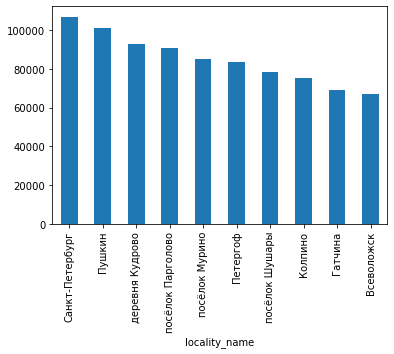

In [94]:
df_10 = df_clients.query('locality_name in @loc_top')
df_gr = df_10.groupby(["locality_name"])["price_mln"].mean().sort_values(ascending = False)
df_gr.plot.bar()

**Вывод: Самая высокая стоимость жилья за 1 кв.м. в Санкт-Петербурге, самая низкая во Всеволожске**

**5. Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге ('locality_name').**

Для анализа необходимо взять только те квартиры, где имеется информация о расстоянии до центра. Среди квартир расположенных в самом Санкт-Петербурге таких 31 единица и для корректности анализа они исключаются из датасета.

In [95]:
df_cpb = df_clients.query("locality_name == 'Санкт-Петербург'")
df_cpb["cityCenters_nearest"].isnull().sum()

31

In [96]:
df_cpb = df_cpb.dropna(subset = ['cityCenters_nearest'])
df_cpb["cityCenters_nearest"].isnull().sum()

0

<AxesSubplot:xlabel='cityCenters_nearest'>

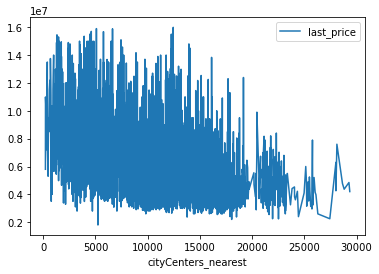

In [97]:
df_cpb_h = df_cpb.pivot_table(index = "cityCenters_nearest", values = "last_price", aggfunc = "mean")
df_cpb_h.plot()

In [98]:
df_cpb['last_price'].corr(df_cpb['cityCenters_nearest'])

-0.37826768837262803

**Вывод: Цена на квартиры расположенные в Санкт-Петербурге имеет обратную корреляцию в зависимости от удаленности от центра города (-0.38).**

**6. Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления).**

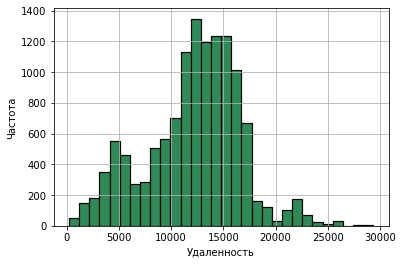

In [99]:
df_cpb['cityCenters_nearest'].hist(bins=30, color = "seagreen", edgecolor='black', linewidth=1.2)
plt.xlabel('Удаленность')
plt.ylabel('Частота') 
plt.show()

In [100]:
df_cpb['cityCenters_nearest'].describe(percentiles = [0.01, 0.05, 0.1, .25, .50, .75])

count   12643.00
mean    12129.66
std      4532.93
min       208.00
1%       1645.00
5%       3867.50
10%      5038.60
25%      9620.50
50%     12645.00
75%     15107.00
max     29343.00
Name: cityCenters_nearest, dtype: float64

In [101]:
center_cpb = df_cpb.query('cityCenters_nearest <= 5000.00') 

Для анализа возьмем квартиры входящие в 0.1 процентиль и  расположенные в радиусе 5 км. от центра города 

In [102]:
center_cpb.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kof,price_mln,w_day,w_month,w_year,liv_tot_area,kit_tot_area
count,1236.00,1236.00,1236.00,1236.00,1236.00,1236.00,1236.00,1236.00,1236.00,460.00,1235.00,1236.00,1236.00,772.00,1236.00,901.00,1068.00,1224.00,1236.00,1236.00,1236.00,1236.00,1236.00,1236.00
mean,9.87,8346452.06,71.21,2.53,3.00,6.28,43.00,3.61,11.11,0.59,23458.26,3522.05,1.00,445.32,1.36,445.45,242.81,0.59,120948.03,2.48,6.56,2017.17,0.59,0.17
std,5.83,2729805.40,21.85,0.99,1.13,4.04,16.91,2.53,3.45,0.92,3518.65,1173.99,0.96,204.15,1.14,278.40,271.27,0.10,33426.31,1.74,3.42,1.07,0.10,0.07
min,0.00,1600000.00,27.00,1.00,2.40,2.00,6.00,1.00,5.00,0.00,17863.00,208.00,0.00,17.00,0.00,22.00,3.00,0.14,17391.30,0.00,1.00,2014.00,0.14,0.05
25%,6.00,6400000.00,54.00,2.00,2.65,4.00,30.30,2.00,8.50,0.00,20810.00,2765.50,0.00,286.75,0.00,206.00,60.00,0.53,96477.56,1.00,3.00,2017.00,0.53,0.12
50%,9.00,8000000.00,70.00,2.00,2.88,5.00,41.90,3.00,10.40,0.00,22966.00,3849.50,1.00,438.50,1.00,430.00,131.00,0.60,114545.45,3.00,7.00,2017.00,0.60,0.15
75%,14.00,10000000.00,88.05,3.00,3.20,6.00,55.00,5.00,13.03,1.00,24808.00,4489.00,2.00,590.25,3.00,664.00,336.25,0.66,138355.26,4.00,10.00,2018.00,0.66,0.20
max,50.00,15800000.00,119.70,6.00,32.00,60.00,90.20,23.00,20.80,5.00,34033.00,4999.00,3.00,1086.00,3.00,1187.00,1497.00,0.87,299000.00,6.00,12.00,2019.00,0.87,0.55


Количество объявлений в центре города составляет 1 236 единиц, что составляет примерно 6 % от общего количества объявлений.

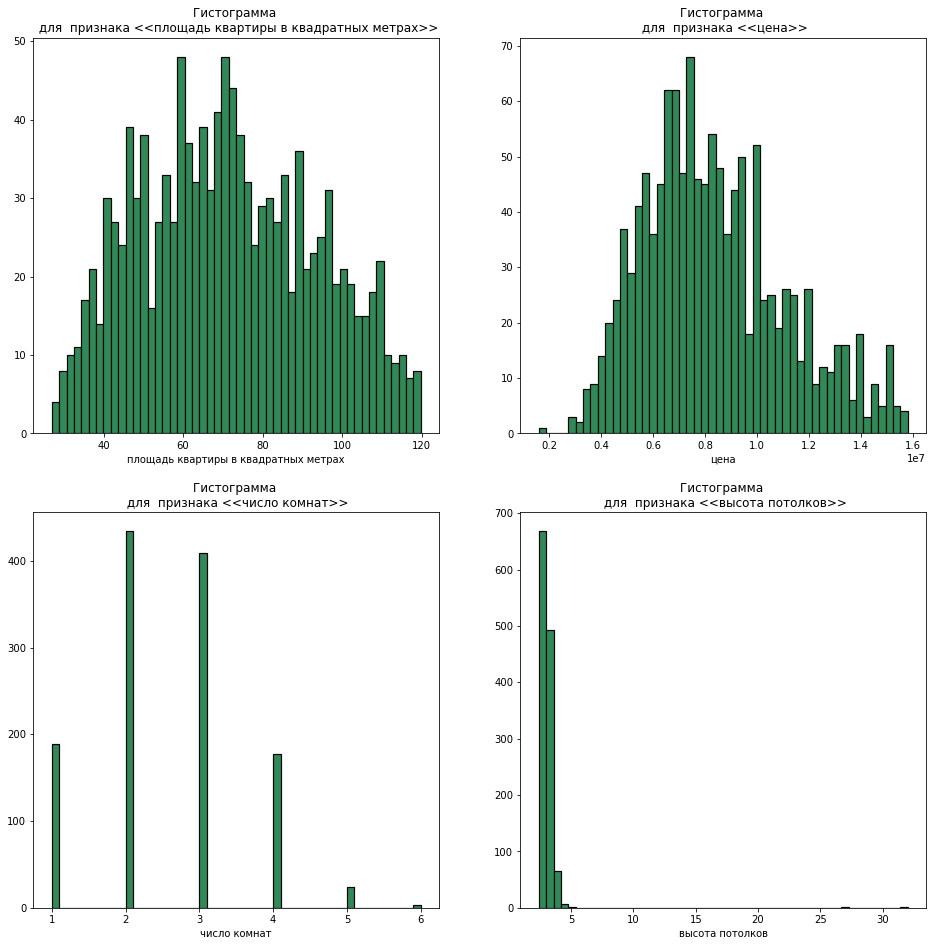

In [103]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(16,16))
i = 0
l = 0
j = 0
for i in range(2):
    for j in range(2):
        axes[i, j].hist(center_cpb[int_v[l]], bins = 50, color = "seagreen", edgecolor='black', linewidth=1.2)
        axes[i, j].set_title("Гистограмма \n для  признака <<{}>>".format(dict_to_rus[int_v[l]]))
        axes[i, j].set_xlabel(dict_to_rus[int_v[l]])
        l+=1

Наиболее продаваемыми квартирами  в центре города являются 2-х и 3-х комнатные квартиры.

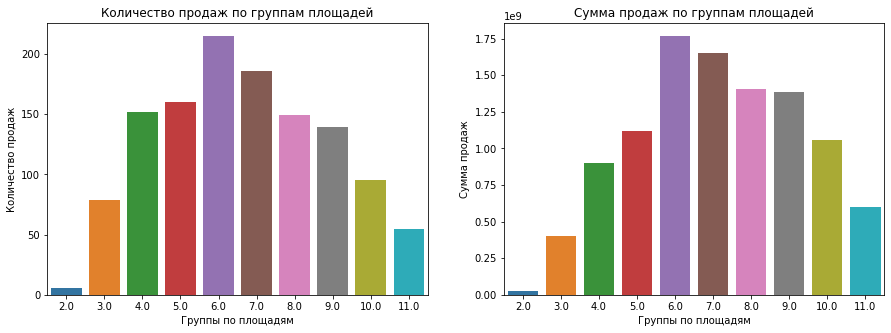

In [104]:
df_cpb_ar = center_cpb[["total_area", "last_price", "rooms", "ceiling_height"]]
df_cpb_ar2 = df_cpb_ar.copy()
df_cpb_ar2["area_grp"] =df_cpb_ar2["total_area"]//10

fig, ax = plt.subplots(1, 2, figsize = (15,5))
plt.subplot(121)

fr6 = df_cpb_ar2.pivot_table(index = "area_grp", values = "last_price", aggfunc = "count").sort_values(by = "last_price", ascending = False)
fr6 = fr6.reset_index().rename_axis(None, axis=1)
plt.title('Количество продаж по группам площадей')
sns.barplot(data=fr6, x='area_grp', y='last_price')
plt.xlabel('Группы по площадям')
plt.ylabel('Количество продаж');

plt.subplot(122)
fr7 = df_cpb_ar2.pivot_table(index = "area_grp", values = "last_price", aggfunc = "sum").sort_values(by = "last_price", ascending = False)
fr7 = fr7.reset_index().rename_axis(None, axis=1)
plt.title('Сумма продаж по группам площадей')
sns.barplot(data=fr7, x='area_grp', y='last_price')
plt.xlabel('Группы по площадям')
plt.ylabel('Сумма продаж');

Анализ количества продаж от Общей площади показал, что больше всех продаются квартиры с площадью от 60 до 70 кв.м., 
 - На втором месте  - квартиры с площадями от 70 до 80 кв.м.

По общей сумме продаж мы видем, что квартиры с площадью от 60 до 70 кв.м. так-же приобладают в анализируемых данных

Text(0, 0.5, 'Средняя цена за 1 кв.м.')

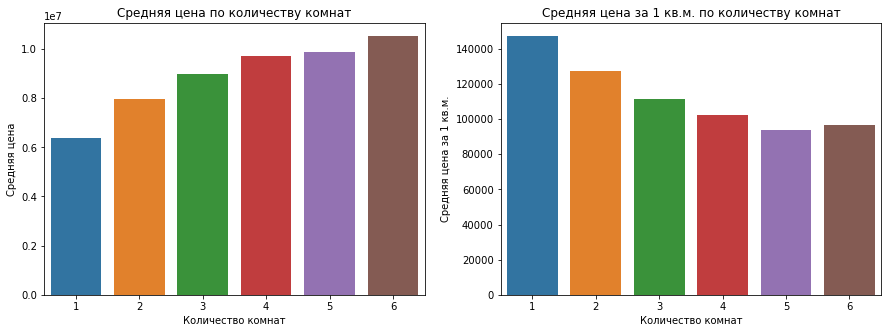

In [105]:
fig, ax = plt.subplots(1, 2, figsize = (15,5))
plt.subplot(121)
h3 = center_cpb.pivot_table(index = "rooms", values= "last_price", aggfunc='mean').sort_values(by='last_price', ascending=False)
h3 = h3.reset_index().rename_axis(None, axis=1)
plt.title('Средняя цена по количеству комнат')
sns.barplot(data=h3, x='rooms', y='last_price')
plt.xlabel('Количество комнат')

plt.ylabel('Средняя цена');
plt.subplot(122)
h24 = center_cpb.pivot_table(index = "rooms", values= "price_mln", aggfunc='mean').sort_values(by='price_mln', ascending=False)
h24 = h24.reset_index().rename_axis(None, axis=1)
plt.title('Средняя цена за 1 кв.м. по количеству комнат')
sns.barplot(data=h24, x='rooms', y='price_mln')
plt.xlabel('Количество комнат')
plt.ylabel('Средняя цена за 1 кв.м.')

Цена  на квартиры расположенные в центре города напрямую зависит от количества комнат - чем больше комнат, тем общая стоимость выша, а цена за 1 кв. метр ниже

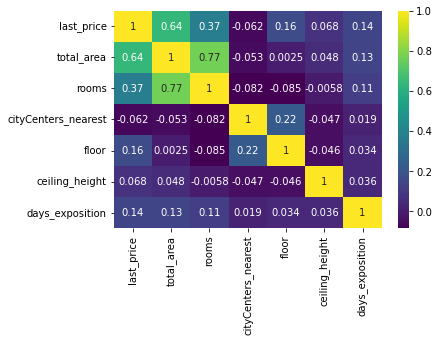

In [106]:
voz3 = center_cpb[["last_price", "total_area", "rooms", "cityCenters_nearest", "floor", "ceiling_height", "days_exposition", "first_day_exposition"]]
corr = voz3.corr()
sns.heatmap(corr, cmap="viridis", annot = True);

In [107]:
par = center_cpb[["last_price", "total_area", "rooms", "cityCenters_nearest", "floor", "ceiling_height", "days_exposition", "first_day_exposition"]]

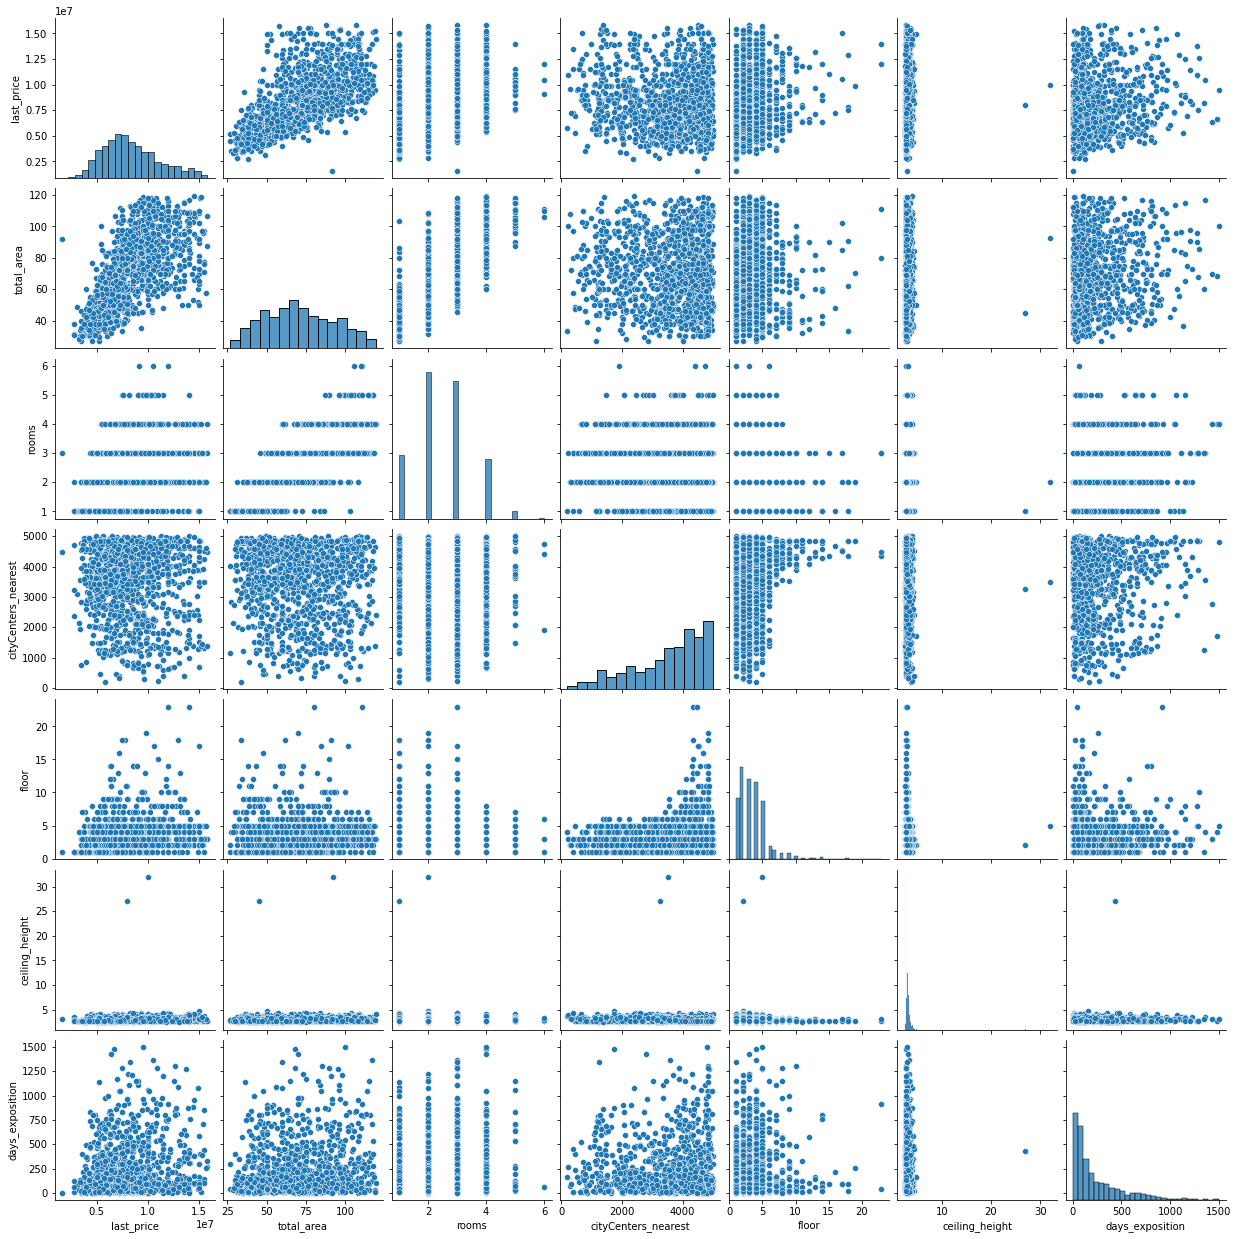

In [108]:
sns.pairplot(par)

В центре города наблюдается прямая зависимость  стоимости квартиры от общей площади.

**Вывод :**
 - Количество объявлений в центре города составляет 1 236 единиц, что составляет примерно 6 % от общего количества объявлений.
 - Наиболее продаваемыми квартирами в центре города являются 2-х и 3-х комнатные квартиры с общей площадью от 60 до 80 кв.м. со средней высотой потолков 2.88 метров
 - Как и в целом по всем объявлениям цена в центре города в основном зависит от общей площади и количества комнат

## $\checkmark$  Проверка гипотезы о равенстве стоимости квартир в центральной части Санкт-Петербурге и других квартир.

С целью корректного анализа добавим в датафрейм столбец  где отдельно выделим объявления о продаже квартир в центре города Санкт-Петербург и отдельно прочие объявления, а так-же исключим пустые значения по сталбцу "Удаленность от центра"

In [109]:
df_clients2 =  df_clients.dropna(subset = ['cityCenters_nearest'])
df_clients2["cityCenters_nearest"].isnull().sum()

0

In [110]:
df_clients2 = df_clients2.copy()

In [111]:
df_clients2["racp"] = df_clients2.apply(lambda x: "Центр Санкт-Петербурга" if (x.cityCenters_nearest <= 5000) & (x.locality_name == "Санкт-Петербург") else "Прочие квартиры", axis=1)

In [112]:
df_clients2.groupby('racp').describe()

total_images                                         \
                              count  mean  std  min  25%   50%   75%   max   
racp                                                                         
Прочие квартиры            13581.00 10.03 5.58 0.00 6.00 10.00 14.00 35.00   
Центр Санкт-Петербурга      1236.00  9.87 5.83 0.00 6.00  9.00 14.00 50.00   

                       last_price                                              \
                            count       mean        std        min        25%   
racp                                                                            
Прочие квартиры          13581.00 5462394.90 2292754.20 1200000.00 3900000.00   
Центр Санкт-Петербурга    1236.00 8346452.06 2729805.40 1600000.00 6400000.00   

                                                          total_area        \
                              50%         75%         max      count  mean   
racp                                                                         
Прочие квартиры        4850000.00  6400000.00 15990000.00   13581.00 53.86   
Центр Санкт-Петербурга 8000000.00 10000000.00 15800000.00    1236.00 71.21   

                                                               rooms       \
                         std   min   25%   50%   75%    max    count mean   
racp                                                                        
Прочие квартиры        18.23 23.40 40.00 50.00 64.00 119.00 13581.00 1.95   
Центр Санкт-Петербурга 21.85 27.00 54.00 70.00 88.05 119.70  1236.00 2.53   

                                                     ceiling_height            \
                        std  min  25%  50%  75%  max          count mean  std   
racp                                                                            
Прочие квартиры        0.88 1.00 1.00 2.00 3.00 6.00       13581.00 2.68 0.60   
Центр Санкт-Петербурга 0.99 1.00 2.00 2.00 3.00 6.00        1236.00 3.00 1.13   

                                                 floors_total                  \
                        min  25%  50%  75%   max        count  mean  std  min   
racp                                                                            
Прочие квартиры        2.30 2.56 2.65 2.70 27.50     13581.00 11.86 6.86 1.00   
Центр Санкт-Петербурга 2.40 2.65 2.88 3.20 32.00      1236.00  6.28 4.04 2.00   

                                             living_area                   \
                        25%  50%   75%   max       count  mean   std  min   
racp                                                                        
Прочие квартиры        6.00 9.00 16.00 60.00    13581.00 30.81 12.91 6.50   
Центр Санкт-Петербурга 4.00 5.00  6.00 60.00     1236.00 43.00 16.91 6.00   

                                                  floor                      \
                         25%   50%   75%   max    count mean  std  min  25%   
racp                                                                          
Прочие квартиры        18.50 29.72 39.80 93.60 13581.00 6.38 5.02 1.00 3.00   
Центр Санкт-Петербурга 30.30 41.90 55.00 90.20  1236.00 3.61 2.53 1.00 2.00   

                                       kitchen_area                       \
                        50%  75%   max        count  mean  std  min  25%   
racp                                                                       
Прочие квартиры        5.00 9.00 33.00     13581.00  9.45 3.11 5.00 7.00   
Центр Санкт-Петербурга 3.00 5.00 23.00      1236.00 11.11 3.45 5.00 8.50   

                                         balcony                           \
                         50%   75%   max   count mean  std  min  25%  50%   
racp                                                                        
Прочие квартиры         9.00 11.00 20.80 7531.00 1.18 1.06 0.00 0.00 1.00   
Центр Санкт-Петербурга 10.40 13.03 20.80  460.00 0.59 0.92 0.00 0.00 0.00   

                                 airports_nearest                             \
        

Из общего числа объявлений 8% - квартиры расположенные в Центре Санкт-Петербурга и 92% - квартиры расположенные в прочих районах. Средняя цена за один квадратный метр для квартир расположенных в центре Санкт-Петербурга на 18% выше, чем в прочих районах

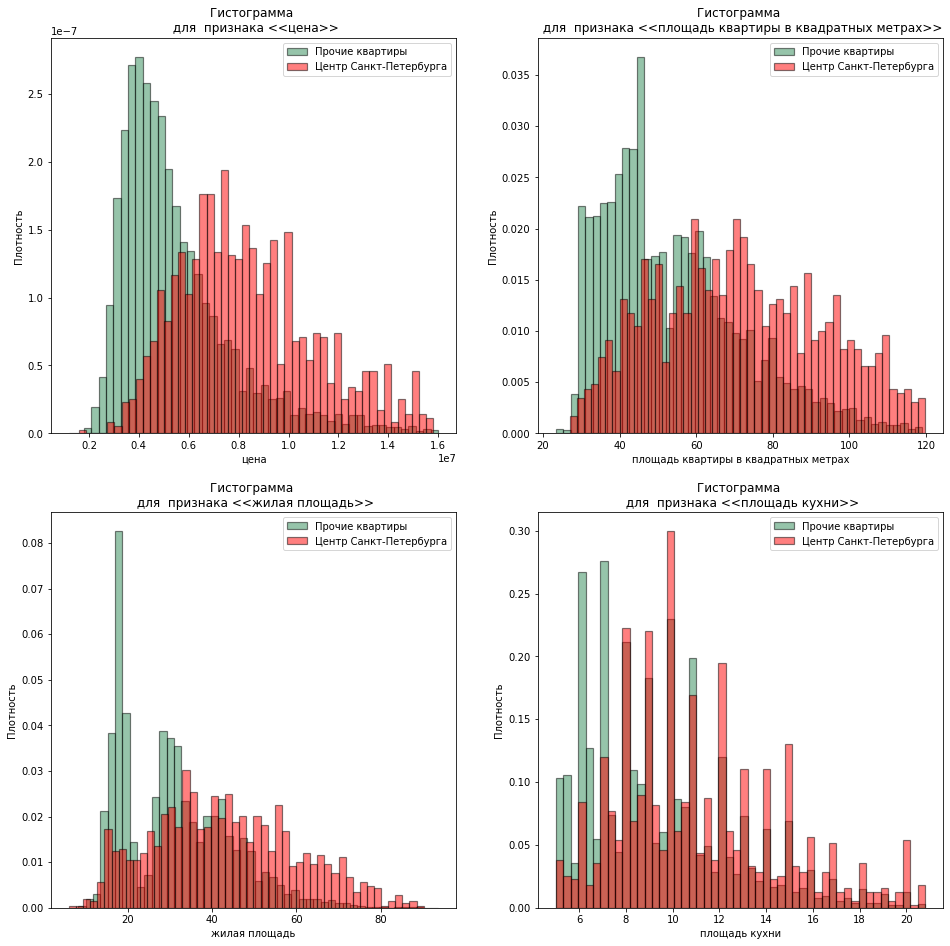

In [113]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(16,16))
i = 0
l = 0
j = 0
for i in range(2):
    for j in range(2):
        axes[i, j].hist(df_clients2[df_clients2.racp == "Прочие квартиры"][int_var[l]], 
                        bins = 50, density=True, color = "seagreen", edgecolor='black', linewidth=1.2, 
                        alpha = 0.5, histtype = 'barstacked', label = 'Прочие квартиры')
        axes[i, j].hist(df_clients2[df_clients2.racp == "Центр Санкт-Петербурга" ][int_var[l]], 
                        bins = 50, density=True,  color = "red", edgecolor='black', linewidth=1.2, 
                        alpha = 0.5, histtype = 'barstacked', label = 'Центр Санкт-Петербурга')
        axes[i, j].set_title("Гистограмма \n для  признака <<{}>>".format(dict_to_rus[int_var[l]]))
        axes[i, j].set_xlabel(dict_to_rus[int_var[l]])
        axes[i, j].set_ylabel('Плотность')
        axes[i, j].legend()
        l+=1

Анализ гистограмм показал, что если в прочих районах продаются в основном  недорогие квартиры, то в Центре Санкт-Петербурга преобладают квартиры в среднем ценовом сегменте, что объясняется тем, что в прочих районах продаются квартиры с небольшой площадью (в среднем - 54 кв.м.), в то время как в Центре Санкт-Петербурга продаются в основном квартиры с большей площадью (в среднем - 71 кв.м.)

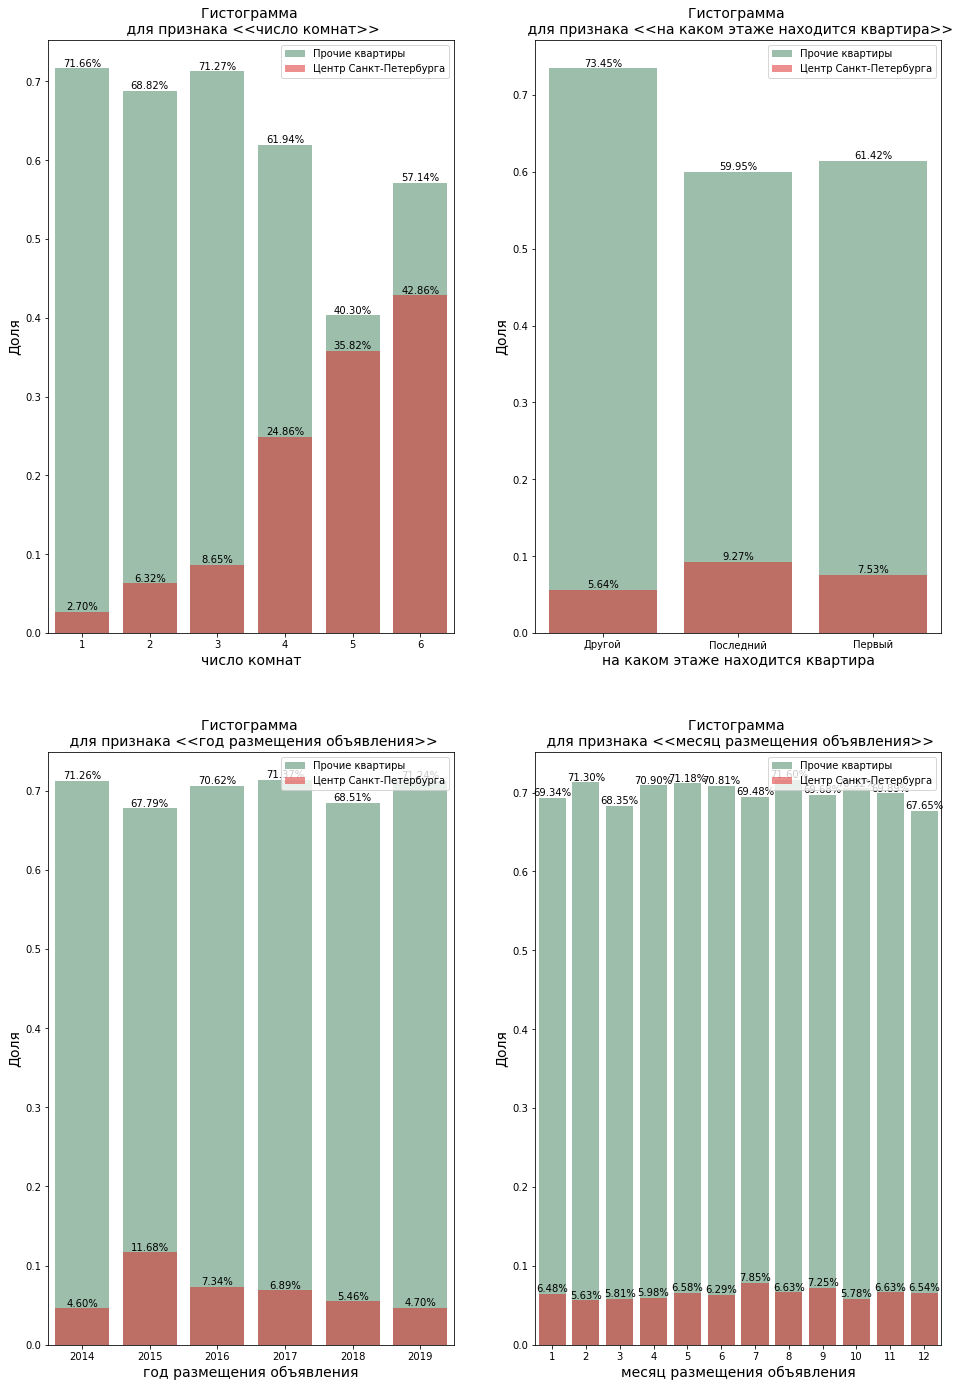

In [114]:

cat_var = ['rooms', 'floor_type', 'w_year', 'w_month']

fig, axes = plt.subplots(2, figsize=(16,24))
i=0
for i, col in enumerate(cat_var):
    plt.subplot(2,2,i+1)
    data_all = df_clients[col].value_counts()
    r = (pd.DataFrame([df_clients2[df_clients2.racp == "Прочие квартиры"][col].value_counts()/data_all, 
              df_clients2[df_clients2.racp == "Центр Санкт-Петербурга"][col].value_counts()/data_all]).T)
    r.columns = ['Прочие квартиры','Центр Санкт-Петербурга']
    ax1 = sns.barplot(x = r.index, y = r['Прочие квартиры'], data = r, color='seagreen',
                      alpha = 0.5, label = 'Прочие квартиры')
    ax2 = sns.barplot(x = r.index, y = r['Центр Санкт-Петербурга'], data = r, color='red', 
                      alpha = 0.5, label = 'Центр Санкт-Петербурга')
    plt.title("Гистограмма \n для признака <<{}>>".format(dict_to_rus[col]), fontsize = 14)
    plt.xlabel(dict_to_rus[col], fontsize = 14)
    plt.ylabel('Доля', fontsize = 14)
    plt.legend()
    for p in ax1.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax1.annotate('{:.2f}%'.format(100*y), 
            (x.mean(), y),ha='center', va='bottom', fontsize = 10)


В центре Санкт-Петербурга продается больше квартир с количеством комнат 5 (36%) и 6 (43%) в то время как в прочих районах продаются небольшие квартиры с количеством комнат -  1 (72%), 2 (69%) и 3 (71%)

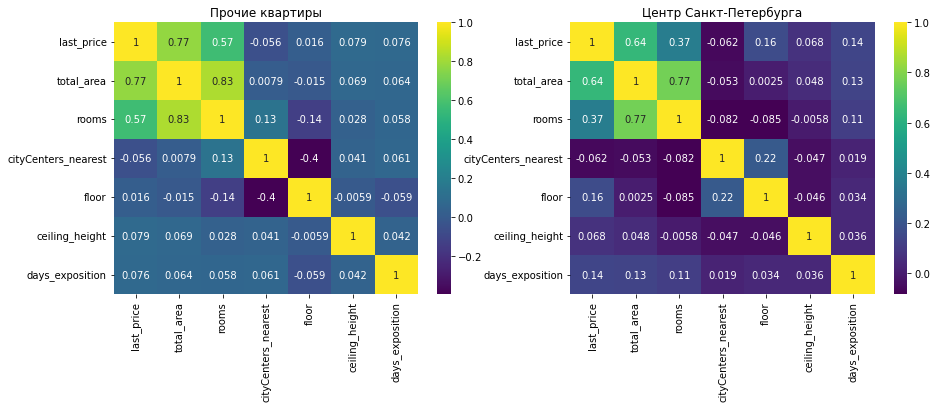

In [115]:
fig, ax = plt.subplots(1, 2, figsize = (15,5))
plt.subplot(121)
df_no_cpb = df_clients2.query("locality_name != 'Санкт-Петербург'")
voz6 = df_no_cpb[["racp","last_price", "total_area", "rooms", "cityCenters_nearest", "floor", "ceiling_height", "days_exposition", "first_day_exposition"]]
corr = voz6.corr()
plt.title('Прочие квартиры')
sns.heatmap(corr, cmap="viridis", annot = True);
plt.subplot(122)
voz3 = center_cpb[["last_price", "total_area", "rooms", "cityCenters_nearest", "floor", "ceiling_height", "days_exposition", "first_day_exposition"]]
corr = voz3.corr()
plt.title('Центр Санкт-Петербурга')
sns.heatmap(corr, cmap="viridis", annot = True);


Цена на квартиры как в прочих районах, так и с центре Санкт-Петербурга в основном зависит от площади и количества комнат

**Вывод:**

Цена на квартиры как в прочих районах, так и с центре Санкт-Петербурга в основном зависит от площади и количества комнат однако сама стоимость квартир в центре на 18% выше, чем в прочих районах, что связано с тем, что:

 - в прочих районах продаются квартиры с небольшой площадью (в среднем - 54 кв.м.), в то время как в Центре Санкт-Петербурга продаются в основном квартиры с большей площадью (в среднем - 71 кв.м.)
 - в центре Санкт-Петербурга продается больше квартир с количеством комнат 5 (36%) и 6 (43%) в то время как в прочих районах продаются небольшие квартиры с количеством комнат - 1 (72%), 2 (69%) и 3 (71%)


## $\checkmark$  Выводы

1. В рамках исследования объявлений о продаже квартир был загружены данные  о продаже квартир в Санкт-Петербурге и соседних населенных пунктов за несколько лет.
2. Проведен первичный анализ данных о продажах квартир, по результатам которого были выявлены ошибочные данные, некорректные типы в данных и пропущенные значения.
3. Выявлено, что дублирующиеся данные в профиле данных отсутствуют.
4. Исключены отклонения в типах данных: дата публикации из типа object приведена к типу datetime; в тех данных, которые предусматривают целочисленное значение, тип float был заменен на int
5. Выявлено и исключено ряд ошибок по ценам, высоте потолков, жилой площади и удаленности от аэропорта. Всего по результатам анализа было исключено 25 объявлений.
6. Проверка по аномальным данным и исключение выбросов производилось с помощью метода сигм и только по критичным для анализа данным - цена и площадь. В результате анализа выявлено и исключено из дальнейшего анализа 4 263 аномальных наблюдений , что составляет 18.01% от общего числа записей.
6. В данных были заполнены столбцы: общее количество этажей (33 объявлений.) и жилая площадь (363 объявлений), высота потолков (9 195 объявлений). Пропущенные значения по столбцу локация были исключены данных  (33 объявлений). В портфеле данных остались столбцы с пропущенными значениями, которые невозможно корректно заполнить, так, чтобы они не повлияли на результаты анализа. При необходимости, при детальном анализе с использованием данных столбцов, пропущенные значения будут исключены из данных.
7. Перед исследовательским анализом были рассчитаны и добавлены в портфель данные о цене квадратного метра; день недели, месяц и год публикации объявления; этаж квартиры; варианты — первый, последний, другой; соотношение жилой и общей площади, а также отношение площади кухни к общей.
8. Проведен Исследовательский анализ данных и сделаны следующие выводы:
 - Наиболее распространенными являются  объявления о продаже 1 и 2 комнатные квартир c общей площадью от 30 до 50 кв.м. включительно и со средней высотой потолка 2.65 м.
 - Больше всего квартир продавалось на 45 день после подачи объявления (522 шт), минимальное количество дней за которые продалась квартира - 1 день с момента публикации объявления, максимальное - 1 580 дней. В среднем квартиры продаются за 97 дней или 3 месяца с момента подачи объявления.
 - Цена напрямую зависит от площади и количества комнат, когда как удаленность от центра города имеет отрицательную корреляцию с ценой, что говорит о том, что чем квартира дальше от центра города, тем дешевле она стоит.
 - На стоимость квартиры также влияет на каком этаже находится квартира - стоимость квартир расположенных между вторым и предпоследним этажом выше, чем по тем, которые находятся на первом и последнем этаже. Самые дешевые квартиры располагаются на первом этаже.
 - Стоимость квартиры никак не зависит от дня недели, месяца или года когда было опубликовано объявление.
 - В топ 10 населенных пунктов - самая высокая стоимость жилья за 1 кв.м. в Санкт-Петербурге, самая низкая во Всеволожске Количество объявлений в центре Санкт-Петербурга составляет 1 236 единиц, что составляет примерно 6 % от общего количества объявлений. Наиболее продаваемыми квартирами в центре города являются 2-х и 3-х комнатные квартиры с общей площадью от 60 до 80 кв.м. со средней высотой потолков 2.88 метров. Как и в целом по всем объявлениям цена в центре Санкт-Петербурга в основном зависит от общей площади и количества комнат
9. Проверена гипотеза о равенстве стоимости квартир в центральной части Санкт-Петербурге и других квартир: Цена на квартиры как в прочих районах, так и с центре Санкт-Петербурга в основном зависит от площади и количества комнат однако сама стоимость квартир в центре на 18% выше, чем в прочих районах, что связано с тем, что:
 - в прочих районах продаются квартиры с небольшой площадью (в среднем - 54 кв.м.), в то время как в Центре Санкт-Петербурга продаются в основном квартиры с большей площадью (в среднем - 71 кв.м.)
 - в центре Санкт-Петербурга продается больше квартир с количеством комнат 5 (36%) и 6 (43%) в то время как в прочих районах продаются небольшие квартиры с количеством комнат - 1 (72%), 2 (69%) и 3 (71%)
